In [1]:
# Import libraries and settings
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import f1_score
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (8, 8)
matplotlib.rcParams.update({'font.size': 16})
import seaborn as sns

## 1.1. Import the monthly and annual data and join

In [2]:
# Run and see response data
Retail_Data_Response = pd.read_csv('Retail_Data_Response.csv')
Retail_Data_Response

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1
...,...,...
6879,CS8996,0
6880,CS8997,0
6881,CS8998,0
6882,CS8999,0


In [3]:
sum(Retail_Data_Response.response.values)

647

In [4]:
# tables needed in 1.1
annual_features = pd.read_excel('annual_features.xlsx')
annual_day_of_week_counts_pivot = pd.read_excel('annual_day_of_week_counts_pivot.xlsx')


In [5]:
annual_features_outputs = annual_features.merge(annual_day_of_week_counts_pivot, on=['customer_id'])
annual_features_outputs = Retail_Data_Response.merge(annual_features_outputs, on=['customer_id'])

annual_features_outputs

,customer_id,response,ann_txn_amt_ave_2011,ann_txn_amt_ave_2012,ann_txn_amt_ave_2013,ann_txn_amt_ave_2014,ann_txn_amt_ave_2015,ann_txn_amt_cnt_2011,ann_txn_amt_cnt_2012,ann_txn_amt_cnt_2013,...,cnt_2014_Thursday,cnt_2014_Tuesday,cnt_2014_Wednesday,cnt_2015_Friday,cnt_2015_Monday,cnt_2015_Saturday,cnt_2015_Sunday,cnt_2015_Thursday,cnt_2015_Tuesday,cnt_2015_Wednesday
0,CS1112,0,70.666667,67.400000,70.666667,70.666667,39.000000,3,5,3,...,1,1,1,0,0,0,0,0,0,1
1,CS1113,0,81.333333,74.800000,85.200000,56.500000,73.333333,3,5,5,...,0,3,0,0,2,0,0,0,0,1
2,CS1114,1,85.200000,75.000000,70.400000,70.833333,79.000000,5,2,5,...,0,1,1,0,0,0,0,1,0,0
3,CS1115,1,87.000000,67.571429,79.571429,78.250000,55.000000,3,7,7,...,2,0,2,0,0,0,0,1,0,0
4,CS1116,1,58.750000,76.666667,59.000000,66.600000,0.000000,4,3,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6879,CS8996,0,31.000000,33.666667,41.500000,56.000000,0.000000,2,3,2,...,1,1,2,0,0,0,0,0,0,0
6880,CS8997,0,45.000000,39.500000,35.166667,42.000000,0.000000,2,4,6,...,0,0,0,0,0,0,0,0,0,0
6881,CS8998,0,64.000000,54.400000,47.000000,32.500000,0.000000,2,5,2,...,0,1,1,0,0,0,0,0,0,0
6882,CS8999,0,52.000000,25.250000,28.000000,21.000000,0.000000,3,4,3,...,0,0,2,0,0,0,0,0,0,0


In [6]:
mth_rolling_features = pd.read_excel('mth_rolling_features.xlsx')
mth_day_counts = pd.read_excel('mth_day_counts.xlsx')
days_since_last_txn = pd.read_excel('days_since_last_txn.xlsx')

In [7]:
# drop the columns that are not needed
mth_rolling_features.drop(columns=['Unnamed: 0'], inplace = True)
mth_day_counts.drop(columns=['Unnamed: 0'], inplace = True)
days_since_last_txn.drop(columns=['Unnamed: 0'], inplace = True)

In [8]:
monthly_features_outputs = mth_day_counts.merge(mth_rolling_features,how='left', on=['CLNT_NO','ME_DT'])
monthly_features_outputs = days_since_last_txn.merge(monthly_features_outputs,how='left', on=['CLNT_NO','ME_DT'])
# we want to merge by customer id, first change column names the same
# monthly_features_outputs.rename(columns={'CLNT_NO': 'customer_id'}) 
monthly_features_outputs = Retail_Data_Response.merge(monthly_features_outputs.rename(columns={'CLNT_NO': 'customer_id'}), how='left', on=['customer_id'])
monthly_features_outputs

,customer_id,response,ME_DT,days_since_last_txn,cnt_Friday,cnt_Monday,cnt_Saturday,cnt_Sunday,cnt_Thursday,cnt_Tuesday,...,amt_max_6M,txn_cnt_sum_6M,txn_cnt_mean_6M,txn_cnt_max_6M,amt_sum_12M,amt_mean_12M,amt_max_12M,txn_cnt_sum_12M,txn_cnt_mean_12M,txn_cnt_max_12M
0,CS1112,0,2011-05-31,-1,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CS1112,0,2011-06-30,15,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CS1112,0,2011-07-31,46,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CS1112,0,2011-08-31,12,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CS1112,0,2011-09-30,42,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323543,CS9000,0,2014-11-30,98,0,0,0,0,0,0,...,35.0,2.0,0.333333,1.0,97.0,8.083333,35.0,4.0,0.333333,1.0
323544,CS9000,0,2014-12-31,129,0,0,0,0,0,0,...,35.0,2.0,0.333333,1.0,97.0,8.083333,35.0,4.0,0.333333,1.0
323545,CS9000,0,2015-01-31,160,0,0,0,0,0,0,...,35.0,1.0,0.166667,1.0,81.0,6.750000,35.0,3.0,0.250000,1.0
323546,CS9000,0,2015-02-28,0,0,0,1,0,0,0,...,34.0,1.0,0.166667,1.0,115.0,9.583333,35.0,4.0,0.333333,1.0


## 1.2. Steps for each method (10 points)

## Annual Features -- LR with L1 regularization

### 1.2.1. Separate the inputs X and the output y in two data frames.

In [9]:
X_annual = annual_features_outputs.drop(columns=['response','customer_id'])
y_annual = annual_features_outputs.response.values
# X_monthly = monthly_features_outputs.drop(columns=['response','customer_id'])
# y_monthly = monthly_features_outputs.response
X_annual

,ann_txn_amt_ave_2011,ann_txn_amt_ave_2012,ann_txn_amt_ave_2013,ann_txn_amt_ave_2014,ann_txn_amt_ave_2015,ann_txn_amt_cnt_2011,ann_txn_amt_cnt_2012,ann_txn_amt_cnt_2013,ann_txn_amt_cnt_2014,ann_txn_amt_cnt_2015,...,cnt_2014_Thursday,cnt_2014_Tuesday,cnt_2014_Wednesday,cnt_2015_Friday,cnt_2015_Monday,cnt_2015_Saturday,cnt_2015_Sunday,cnt_2015_Thursday,cnt_2015_Tuesday,cnt_2015_Wednesday
0,70.666667,67.400000,70.666667,70.666667,39.000000,3,5,3,3,1,...,1,1,1,0,0,0,0,0,0,1
1,81.333333,74.800000,85.200000,56.500000,73.333333,3,5,5,4,3,...,0,3,0,0,2,0,0,0,0,1
2,85.200000,75.000000,70.400000,70.833333,79.000000,5,2,5,6,1,...,0,1,1,0,0,0,0,1,0,0
3,87.000000,67.571429,79.571429,78.250000,55.000000,3,7,7,4,1,...,2,0,2,0,0,0,0,1,0,0
4,58.750000,76.666667,59.000000,66.600000,0.000000,4,3,1,5,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6879,31.000000,33.666667,41.500000,56.000000,0.000000,2,3,2,6,0,...,1,1,2,0,0,0,0,0,0,0
6880,45.000000,39.500000,35.166667,42.000000,0.000000,2,4,6,2,0,...,0,0,0,0,0,0,0,0,0,0
6881,64.000000,54.400000,47.000000,32.500000,0.000000,2,5,2,4,0,...,0,1,1,0,0,0,0,0,0,0
6882,52.000000,25.250000,28.000000,21.000000,0.000000,3,4,3,2,0,...,0,0,2,0,0,0,0,0,0,0


In [10]:
annual_features_outputs.response.values

array([0, 0, 1, ..., 0, 0, 0])

### 1.2.2. Split the data in train and test set.

In [11]:
from sklearn.model_selection import train_test_split
X_train_annual, X_test_annual, y_train_annual, y_test_annual = train_test_split(
    X_annual, y_annual, test_size=2/3, random_state=1147)

# X_train_monthly, X_test_monthly, y_train_monthly, y_test_monthly = train_test_split(
#     X_monthly, y_monthly, test_size=2/3, random_state=1147)

# X_train_annual 2294*75
# X_test_annual 4590*75
# y_train_annual 2294*1

### 1.2.3. Pre-process (if necessary for the method).
Here I standardized the training and test data

In [12]:
scaler = StandardScaler()
Xs_train_annual = scaler.fit_transform(X_train_annual)
Xs_test_annual = scaler.transform(X_test_annual)
# Xs_train_annual = X_train_annual
# Xs_test_annual = X_test_annual
Xs_test_annual.mean(axis=0)

array([ 0.03369577, -0.0005918 ,  0.04806546, -0.00541917,  0.00802146,
        0.02524238,  0.03638879,  0.00534487, -0.02116867, -0.02746224,
        0.03538708,  0.00234805,  0.04951677,  0.00570297,  0.00847802,
        0.02726526, -0.01516364,  0.02010925,  0.01832721,  0.00651649,
        0.00102959, -0.0223382 ,  0.03528297, -0.01850721,  0.0199354 ,
        0.00861292, -0.00135738,  0.0408861 , -0.02026149,  0.01495823,
        0.02462251,  0.03819298,  0.01225422, -0.01831344, -0.01972147,
       -0.00042862, -0.00129379,  0.02904655, -0.01418203,  0.0265407 ,
       -0.04463719,  0.02960931,  0.03691719,  0.02834006,  0.00105129,
        0.03735499, -0.01564599,  0.04832395,  0.0246237 ,  0.00770538,
        0.01212578,  0.01342323, -0.00089467, -0.00429158, -0.02020068,
        0.01276314, -0.01802804,  0.05520218, -0.02550258,  0.01640774,
       -0.00290698,  0.00596058, -0.04350865,  0.01174595,  0.01783491,
       -0.00283438,  0.00128507, -0.04717341,  0.01673447, -0.01

### 1.2.4. Fit the training dataset and optimize the hyperparameters of the method.


In [15]:
scores_train_LR.shape

(2294,)

In [14]:
# ===================================== #
# === [Sklearn Model Configuration] === #
# ===================================== #

C = np.linspace(0.001, 0.5, 20)
# Smaller values, stronger regularization, more coefficients will go to zero

# Initialize the variables you want to save in an iterative manner
count                     = -1
Train_AUC_iter_LR         = np.zeros(shape=(len(C),1))
Test_AUC_iter_LR          = np.zeros(shape=(len(C),1))
NonZeroCoeff_LR           = np.zeros(shape=(len(C),1))
Model_Coeff_LR            = np.zeros(shape=(X_annual.shape[1], len(C)))
Train_accuracy_iter_LR    = np.zeros(shape=(len(C),1))
Test_accuracy_iter_LR    = np.zeros(shape=(len(C),1))


fig = plt.figure(figsize=(16, 16))

for c in C:
    count += 1
    # instantiate a logistic regression model, and fit with X and y
    model_LR = LogisticRegression(C=c, penalty='l1', solver="liblinear",random_state=1147)
    # Fit the model
    model_LR.fit(Xs_train_annual, y_train_annual)
    Model_Coeff_LR[:,count] = model_LR.coef_[0,:]
    # Scores for train set
    scores_train_LR = model_LR.predict_proba(Xs_train_annual)[:, 1]
    # Scores for test set
    scores_test_LR = model_LR.predict_proba(Xs_test_annual)[:, 1]
    # predict the class
    y_train_annual_predicted = model_LR.predict(Xs_train_annual)
    y_test_annual_predicted = model_LR.predict(Xs_test_annual)
    
    # ============================ #
    # === [Train: ROC and AUC] === #
    # ============================ #
    # ROC Calc
    fpr_train_LR, tpr_train_LR, _ = roc_curve(y_train_annual, scores_train_LR)
    # AUC Calc
    auc_train_LR = auc(fpr_train_LR, tpr_train_LR)
    Train_AUC_iter_LR[count,0] = auc_train_LR
    # ============================ #
    # === [Test: ROC and AUC] === #
    # ============================ #
    # ROC Calc
    fpr_test_LR, tpr_test_LR, _ = roc_curve(y_test_annual, scores_test_LR)
    # AUC Calc
    auc_test_LR = auc(fpr_test_LR, tpr_test_LR)
    Test_AUC_iter_LR[count,0] = auc_test_LR
    ### Extract the count of non-zero coefficients
    NonZeroCoeff_LR[count,0] = X_annual.shape[1] - (model_LR.coef_ == 0).sum()
    
    ### Accuracy ###
    Train_accuracy_iter_LR[count,0]=(100*accuracy_score(y_train_annual, y_train_annual_predicted, normalize = True))
    Test_accuracy_iter_LR[count,0]=(100*accuracy_score(y_test_annual, y_test_annual_predicted, normalize = True))
    
    x = model_LR.coef_.transpose()   
    index = np.arange(len(x))  
    




<Figure size 1152x1152 with 0 Axes>

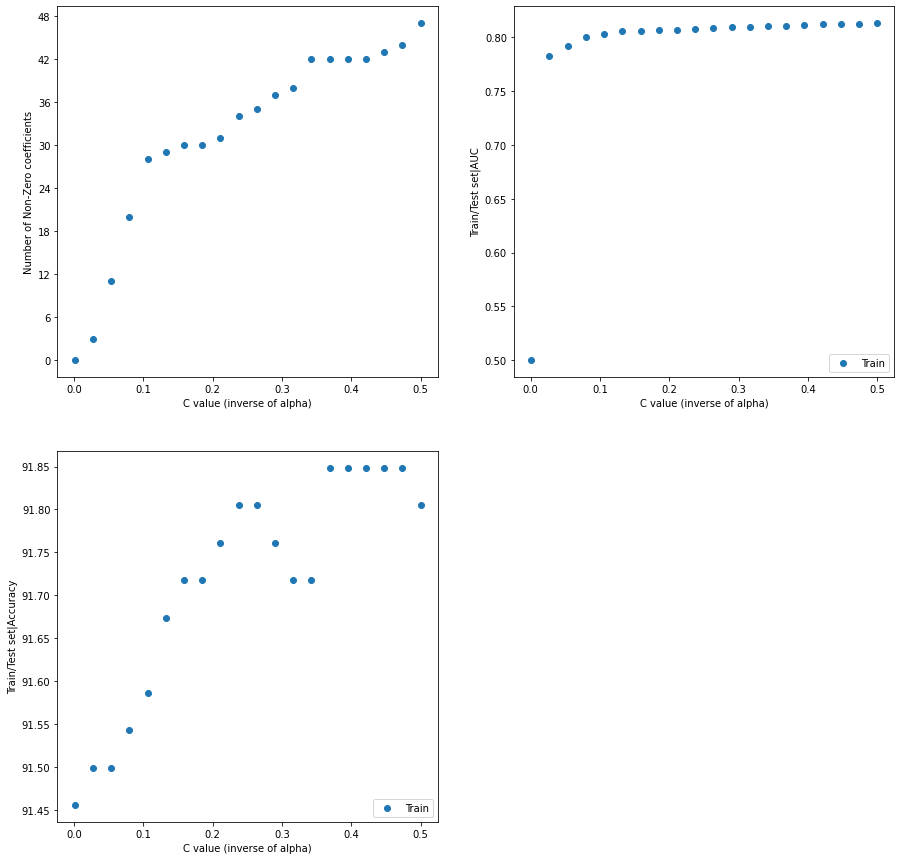

In [16]:
# Plot of the NonZero coefficients    
fig = plt.figure(figsize=(15, 15))
sub1 = fig.add_subplot(221)
plt.scatter(C, NonZeroCoeff_LR)
sub1.set_ylabel('Number of Non-Zero coefficients')
sub1.set_xlabel('C value (inverse of alpha)')
sub1.yaxis.set_major_locator(MaxNLocator(integer=True))
# sub1.set_xlim(0.01,1)
# plt.xscale('log')
# plt.show()

sub2 = fig.add_subplot(222)
plt.scatter(C,Train_AUC_iter_LR)
# plt.scatter(C,Test_AUC_iter_LR)
sub2.set_xlabel('C value (inverse of alpha)')
sub2.set_ylabel('Train/Test set|AUC')
# sub1.set_xlim(0.02,0.06)
# plt.annotate('AUC= %0.3f' %(Test_AUC_iter_LR[8]), xy=(C[8], 1.003*Test_AUC_iter_LR[8]), xycoords='data',horizontalalignment= 'left', fontsize = 12)
# plt.annotate('AUC= %0.3f' %(Train_AUC_iter_LR[8]), xy=(0.9*C[8], 1.003*Train_AUC_iter_LR[8]), xycoords='data',horizontalalignment= 'right', fontsize = 12)
plt.legend(['Train'], loc ='lower right')

sub3 = fig.add_subplot(223)
plt.scatter(C,Train_accuracy_iter_LR)
# plt.scatter(C,Test_accuracy_iter_LR)
sub3.set_xlabel('C value (inverse of alpha)')
sub3.set_ylabel('Train/Test set|Accuracy')
plt.legend(['Train'], loc ='lower right')
# plt.axhline(Test_AUC_iter_LR[8], color = 'k', linestyle = '--')
# plt.axvline(C[8], color = 'k', linestyle = '--')
# plt.plot([C[8],C[8]],[plt.ylim()[0],Test_AUC_iter_LR[8]])
# plt.xscale('log')

plt.show()

I would choose c=0.1 as best parameter here, since AUC tends to be in plautau after value of 0.2, accuracy for train and test are fairly high (more than 0.9).

In [17]:
# create and fit best model
model_LR_best = LogisticRegression(C=0.2, penalty='l1', solver="liblinear",random_state=1147)
# Fit the model
model_LR_best.fit(Xs_train_annual, y_train_annual)

LogisticRegression(C=0.2, penalty='l1', random_state=1147, solver='liblinear')

### 1.2.5. Plot coefficient values or feature importance

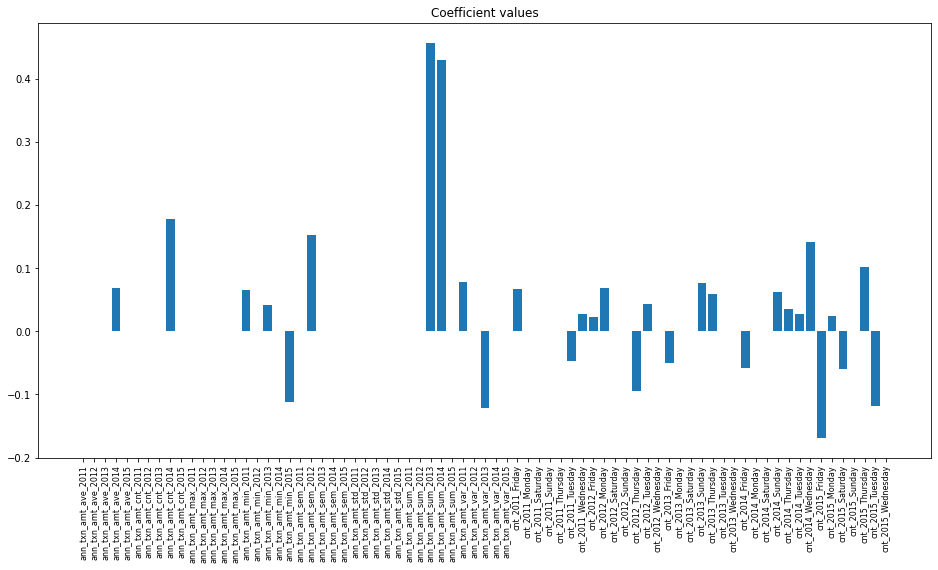

In [18]:
# coefficients
m = model_LR_best.coef_
# intercept
b = model_LR_best.intercept_

# Create plot
plt.figure(figsize=(16,8)) 
# Create plot title
plt.title("Coefficient values")
# Add bars
plt.bar(range(Xs_train_annual.shape[1]), m[0])
# Add feature names as x-axis labels
plt.xticks(range(Xs_train_annual.shape[1]), X_annual.columns, rotation=90,size=8)
# Show plot
plt.show()

In [19]:
m

array([[ 0.        ,  0.        ,  0.        ,  0.06924447,  0.        ,
         0.        ,  0.        ,  0.        ,  0.17814655,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.06617264,  0.        ,  0.04159613,  0.        , -0.11208455,
         0.        ,  0.15278879,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.45736725,  0.43034701,  0.        ,
         0.077453  ,  0.        , -0.12199199,  0.        ,  0.        ,
         0.06721519,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.04636979,  0.0270597 ,  0.02215019,  0.06917062,  0.        ,
         0.        , -0.0940079 ,  0.04286521,  0.        , -0.05031581,
         0.        ,  0.        ,  0.07602629,  0.0595378 ,  0.        ,
         0.        , -0.05828695,  0.        ,  0.        ,  0.06308116,
         0.03511056,  0.02680607,  0.14092162, -0.1

### 1.2.6. Plot probability distribution for test set.

In [20]:
# fit test set
y_test_proba = model_LR_best.predict_proba(Xs_test_annual)
y_test_proba.shape

(4590, 2)

ValueError: Cannot mask with non-boolean array containing NA / NaN values

<Figure size 360x360 with 0 Axes>

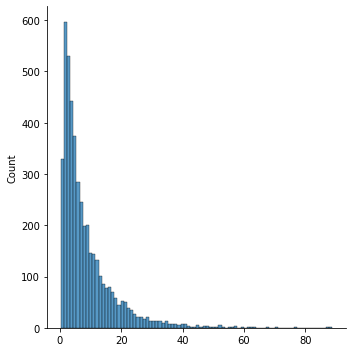

In [22]:
plt.figure(figsize=(5,5))
sns.displot(data = y_test_proba[:,1], x = 100*y_test_proba[:,1])
plt.title('Distribution of probabilities to positive response to campaign',size=18)
plt.xlabel('Probability positive response (%)',size=15)
plt.ylabel('Counts of clients',size=15)
plt.show()

Here, we can see the probability distribution is right skewed, most of the clients have low probability(less than 30%) of positive resonse, very few people have high possibility of positive response.

### 1.2.7. Plot confusion matrix and ROC curves of train/test set.

In [23]:
from sklearn.metrics import confusion_matrix
y_train_predicted = model_LR_best.predict(Xs_train_annual)
y_test_predicted = model_LR_best.predict(Xs_test_annual)
cm_train = confusion_matrix(y_train_annual, y_train_predicted)
cm_test = confusion_matrix(y_test_annual, y_test_predicted)

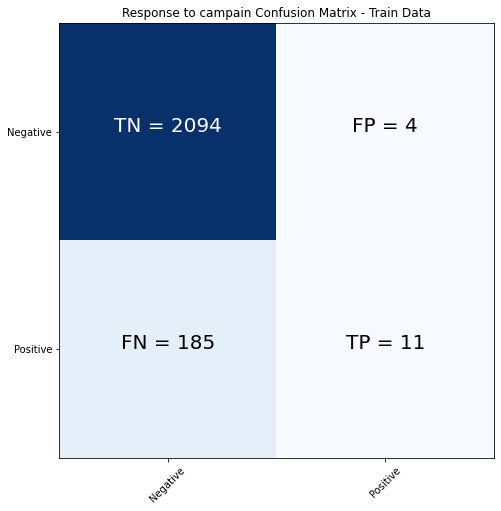

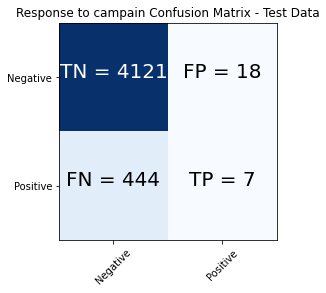

In [24]:
fig = plt.figure(figsize=(8,8))
sub1 = fig.add_subplot(121)
plt.clf()
plt.imshow(cm_train, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
plt.title('Response to campain Confusion Matrix - Train Data')
sub1.set_ylabel('True label')
sub1.set_xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm_train.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm_train[i][j]), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm_train[i, j] > thresh else "black")

plt.show()
        
sub2 = fig.add_subplot(122)        
plt.clf()
plt.imshow(cm_test, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
plt.title('Response to campain Confusion Matrix - Test Data')
sub2.set_ylabel('True label')
sub2.set_xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm_test.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm_test[i][j]), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm_test[i, j] > thresh else "black")

plt.show()

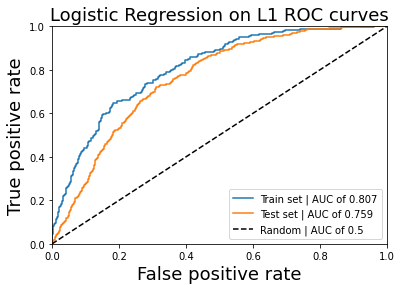

In [25]:
# Scores for train set
scores_train = model_LR_best.predict_proba(Xs_train_annual)[:, 1]
# Scores for test set
scores_test = model_LR_best.predict_proba(Xs_test_annual)[:, 1]

# ROC Calc Train set
fpr_train, tpr_train, _ = roc_curve(y_train_annual, scores_train)
# ROC Calc Test set
fpr_test, tpr_test, _ = roc_curve(y_test_annual, scores_test)
# AUC Calc
auc_train = auc(fpr_train, tpr_train)
# AUC Calc
auc_test  = auc(fpr_test, tpr_test)

# Plotting
plt.plot(fpr_train, tpr_train, label='Train set | AUC of {:4.3f}'.format(auc_train));
plt.plot(fpr_test, tpr_test, label='Test set | AUC of {:4.3f}'.format(auc_test));
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5');
plt.ylim([0,1.0])
plt.xlim([0,1.0])
plt.title('Logistic Regression on L1 ROC curves', fontsize = 18)
plt.ylabel('True positive rate', fontsize = 18)
plt.xlabel('False positive rate', fontsize = 18)
plt.legend()
plt.show()

Calculate Precision/Recall

In [26]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
print('Precision/Recall for training set')
print(classification_report(y_train_annual, y_train_predicted, target_names = ['Negative', 'Positive']))
print('---------------------------------------------------------')
print('Precision/Recall for test set')
print(classification_report(y_test_annual, y_test_predicted, target_names = ['Negative', 'Positive']))

Precision/Recall for training set
              precision    recall  f1-score   support

    Negative       0.92      1.00      0.96      2098
    Positive       0.73      0.06      0.10       196

    accuracy                           0.92      2294
   macro avg       0.83      0.53      0.53      2294
weighted avg       0.90      0.92      0.88      2294

---------------------------------------------------------
Precision/Recall for test set
              precision    recall  f1-score   support

    Negative       0.90      1.00      0.95      4139
    Positive       0.28      0.02      0.03       451

    accuracy                           0.90      4590
   macro avg       0.59      0.51      0.49      4590
weighted avg       0.84      0.90      0.86      4590




### 1.2.8. Plot decision boundary for top 2 features.

From the coefficient value plot, we can see that the top 2 features are txn_ann_amt_sum_2013 and txn_ann_amt_sum_2014.

In [27]:
Xs_train_annual.min(axis=0)
Xs_train_annual.max(axis=0)

array([2.01564977, 2.54832855, 2.32853231, 2.37365373, 1.86797862,
       4.3878047 , 4.95884344, 5.13218962, 3.66949389, 4.89857762,
       1.11665108, 1.06357449, 1.04550882, 1.04423056, 1.62452522,
       2.77748075, 3.79052899, 3.61651645, 3.66578692, 2.07245992,
       3.92358353, 5.15194312, 5.45634823, 5.06914927, 5.44149189,
       3.03565994, 3.45243077, 3.71128793, 3.46350684, 5.02233636,
       4.85491351, 5.32578845, 5.53912437, 3.82466818, 6.40690254,
       5.49310688, 6.1829347 , 6.87106086, 6.02377938, 8.51328015,
       6.87738617, 5.66306624, 5.56704867, 5.61704228, 3.95143419,
       5.36919722, 5.33539908, 5.35184237, 6.35516206, 3.96152895,
       5.41592301, 6.36509833, 4.07502142, 5.19424743, 5.16034199,
       6.15838439, 5.11645198, 6.69537318, 7.43922983, 6.3878855 ,
       5.07945414, 5.49891078, 5.18694457, 6.3057124 , 5.30536028,
       4.18348882, 4.21335075, 6.2942375 , 7.3726854 , 4.84964941,
       7.83126309, 7.6050914 , 7.86242123, 7.54230352, 7.65238

In [28]:
m

array([[ 0.        ,  0.        ,  0.        ,  0.06924447,  0.        ,
         0.        ,  0.        ,  0.        ,  0.17814655,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.06617264,  0.        ,  0.04159613,  0.        , -0.11208455,
         0.        ,  0.15278879,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.45736725,  0.43034701,  0.        ,
         0.077453  ,  0.        , -0.12199199,  0.        ,  0.        ,
         0.06721519,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.04636979,  0.0270597 ,  0.02215019,  0.06917062,  0.        ,
         0.        , -0.0940079 ,  0.04286521,  0.        , -0.05031581,
         0.        ,  0.        ,  0.07602629,  0.0595378 ,  0.        ,
         0.        , -0.05828695,  0.        ,  0.        ,  0.06308116,
         0.03511056,  0.02680607,  0.14092162, -0.1

In [29]:
min_max = pd.DataFrame(np.stack((Xs_train_annual.min(axis=0),Xs_train_annual.max(axis=0))), columns=X_annual.columns)
# np.stack((Xs_train_annual.min(axis=0),Xs_train_annual.max(axis=0)))

print(min_max.ann_txn_amt_sum_2013.values)
print(min_max.ann_txn_amt_sum_2014.values)

[-1.6977425   5.53912437]
[-1.75526672  3.82466818]


In [30]:
xx, yy = np.mgrid[-1.7:5.6:0.81, -1.8:3.9:0.63] # The steps 1.1111 and 1.75 were selected to create a 10x10 grid
grid = np.c_[xx.ravel(), yy.ravel()]
grid.shape # Confirm that grid shape is 10x10


(100, 2)

In [31]:
# np.ones is a table full of ones with 100x23 dimension
# np.median calculates the median of every column in the X_train along axis=0 (i.e. column)
median_inputs = np.ones((100, 75)) * np.median(Xs_train_annual, axis=0) 
median_inputs = pd.DataFrame(median_inputs,columns=X_annual.columns) # Convert to pandas is not necessary. Just doing it here to have a nice view of the table

In [32]:
# Then, we replace the ann_txn_amt_sum_2013 & 2014 column with the values of the grid
median_inputs.ann_txn_amt_sum_2013 = grid[:,0]
median_inputs.ann_txn_amt_sum_2014 = grid[:,1]

median_inputs.ann_txn_amt_sum_2013
# df = pd.DataFrame(median_inputs).iloc[:13,:12] # Convert to pandas is not necessary. Just doing it here to have a nice view of the table
# df.style.apply(lambda x: ['background: grey' if (x.name == 5)|(x.name == 11)  else '' for i in x])

0    -1.70
1    -1.70
2    -1.70
3    -1.70
4    -1.70
      ... 
95    5.59
96    5.59
97    5.59
98    5.59
99    5.59
Name: ann_txn_amt_sum_2013, Length: 100, dtype: float64

In [33]:
median_inputs.iloc[:,32] # ann_txn_amt_sum_2013

0    -1.70
1    -1.70
2    -1.70
3    -1.70
4    -1.70
      ... 
95    5.59
96    5.59
97    5.59
98    5.59
99    5.59
Name: ann_txn_amt_sum_2013, Length: 100, dtype: float64

In [34]:
median_inputs.iloc[:,33] # ann_txn_amt_sum_2014

0    -1.80
1    -1.17
2    -0.54
3     0.09
4     0.72
      ... 
95    1.35
96    1.98
97    2.61
98    3.24
99    3.87
Name: ann_txn_amt_sum_2014, Length: 100, dtype: float64

In [35]:
# Score the artificial data on the grid
probs = model_LR_best.predict_proba(median_inputs.values)[:, 1].reshape(xx.shape)

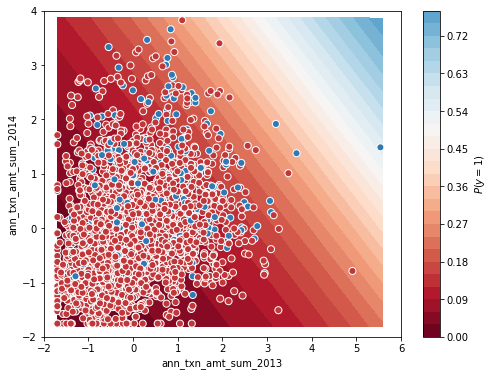

In [36]:

f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
# ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(Xs_train_annual[:,32], Xs_train_annual[:, 33], c=y_train_annual[:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(aspect="auto",
       xlim=(-2,6), ylim=(-2,4),
       xlabel="ann_txn_amt_sum_2013", ylabel="ann_txn_amt_sum_2014")
plt.show()

## Annual Features -- Decision Tree

### 1.2.3. Pre-process (if necessary for the method).

We don't need standardization for decision tree, because it is not a distance based analysis method.

### 1.2.4. Fit the training dataset and optimize the hyperparameters of the method.

In [37]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
# Initiate some parameters that I want to track in the iteration below
max_depth_range = range(1, 20)
estimator_max_depth = []
accuracy_normalized = []
auc_train           = []
auc_test            = []
f1_test             = []

for i in max_depth_range:
    # Define and fit
    estimator_max_depth.append(DecisionTreeClassifier(random_state=1147, max_depth = i))
    estimator_max_depth[i-1].fit(X_train_annual, y_train_annual)
    # Score train and test set ############### we don't need to store this in every iteration so we can overwrite it ###############
    scores_train = estimator_max_depth[i-1].predict_proba(X_train_annual)[:,1] 
    scores_test  = estimator_max_depth[i-1].predict_proba(X_test_annual)[:,1]  
    # Predict the class of test set
    y_test_predicted = estimator_max_depth[i-1].predict(X_test_annual)
    # Calculate accuracy at every iteration and append
    accuracy_normalized.append(100*accuracy_score(y_test_annual, y_test_predicted, normalize = True))
    # ROC Calc Train set ############### we don't need to store this in every iteration so we can overwrite it ###############
    fpr_train, tpr_train, _ = roc_curve(y_train_annual, scores_train)
    # ROC Calc Test set ############### we don't need to store this in every iteration so we can overwrite it ###############
    fpr_test, tpr_test, _ = roc_curve(y_test_annual, scores_test)
    # Calculate the AUCs
    auc_train.append(auc(fpr_train, tpr_train))
    auc_test.append(auc(fpr_test, tpr_test))
    # Calculate F1
    f1_test.append(f1_score(y_test_annual, y_test_predicted)) 

In [38]:
performance_dictionary = {'ACCURACY': accuracy_normalized, 
                          'AUC_TRAIN': auc_train,
                          'AUC_TEST': auc_test,
                          'F1_Test': f1_test}
performance_df = pd.DataFrame(performance_dictionary)
performance_df['MAX_DEPTH'] = performance_df.index + 1
performance_df

,ACCURACY,AUC_TRAIN,AUC_TEST,F1_Test,MAX_DEPTH
0,90.174292,0.700504,0.678205,0.000000,1
1,90.174292,0.736396,0.697802,0.000000,2
2,90.174292,0.762659,0.704718,0.000000,3
3,89.455338,0.792137,0.721851,0.126354,4
4,89.498911,0.835687,0.733068,0.133094,5
5,89.302832,0.869209,0.698132,0.121646,6
6,87.668845,0.896951,0.682511,0.107256,7
7,87.450980,0.922038,0.686843,0.145401,8
8,87.211329,0.938444,0.683201,0.148041,9
9,86.405229,0.955599,0.682644,0.142857,10


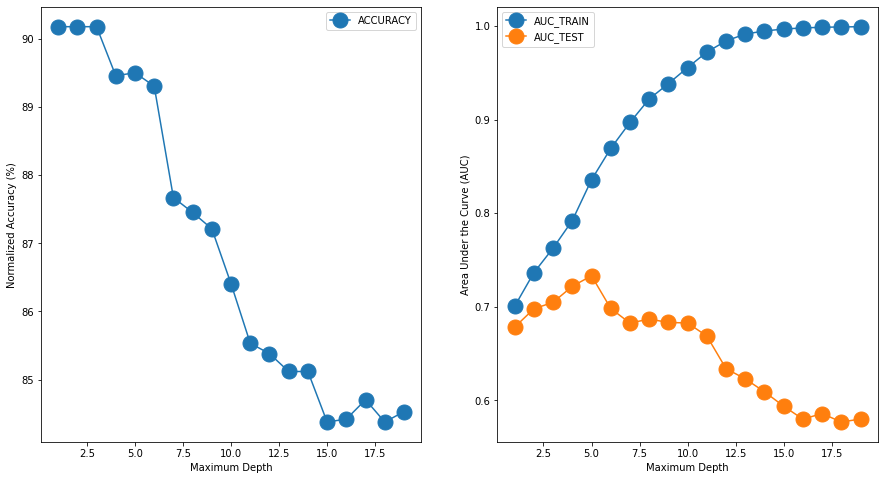

In [39]:
fig_1 = plt.figure(figsize=(15,8))

fig_1_a = plt.subplot(121)
ax1 = performance_df.plot(x = 'MAX_DEPTH', y = 'ACCURACY', ax = fig_1_a, style = 'o-', markersize =15)
ax1.set_ylabel("Normalized Accuracy (%)")
ax1.set_xlabel("Maximum Depth")

fig_1_b = plt.subplot(122)
ax2 = performance_df.plot(x = 'MAX_DEPTH', y = 'AUC_TRAIN', ax = fig_1_b, style = 'o-', markersize =15)
ax2 = performance_df.plot(x = 'MAX_DEPTH', y = 'AUC_TEST', ax = fig_1_b, style = 'o-', markersize =15)
ax2.set_xlabel("Maximum Depth")
ax2.set_ylabel("Area Under the Curve (AUC)")
# ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

From the above, we can see that depth of 11 leads to relatively high test AUC (0.67), without dropping the accuracy below 0.85, as well as a higher F1 score(0.16).

In [40]:
# Initiate some parameters that I want to track in the iteration below
min_split_range = [5,10,20,30,50,60,80]
estimator_min_split = []
accuracy_normalized = []
auc_train           = []
auc_test            = []
f1_test             = []

n=0
for i in min_split_range:
    # Define and fit
    estimator_min_split.append(DecisionTreeClassifier(random_state=1147, max_depth = 11, min_samples_split=i))
    estimator_min_split[n].fit(X_train_annual, y_train_annual)
    # Score train and test set ############### we don't need to store this in every iteration so we can overwrite it ###############
    scores_train = estimator_min_split[n].predict_proba(X_train_annual)[:,1] 
    scores_test  = estimator_min_split[n].predict_proba(X_test_annual)[:,1]  
    # Predict the class of test set
    y_test_predicted = estimator_min_split[n].predict(X_test_annual)
    # Calculate accuracy at every iteration and append
    accuracy_normalized.append(100*accuracy_score(y_test_annual, y_test_predicted, normalize = True))
    # ROC Calc Train set ############### we don't need to store this in every iteration so we can overwrite it ###############
    fpr_train, tpr_train, _ = roc_curve(y_train_annual, scores_train)
    # ROC Calc Test set ############### we don't need to store this in every iteration so we can overwrite it ###############
    fpr_test, tpr_test, _ = roc_curve(y_test_annual, scores_test)
    # Calculate the AUCs
    auc_train.append(auc(fpr_train, tpr_train))
    auc_test.append(auc(fpr_test, tpr_test))
    # Calculate F1
    f1_test.append(f1_score(y_test_annual, y_test_predicted)) 
    n+=1

In [41]:
performance_dictionary = {'ACCURACY': accuracy_normalized, 
                          'AUC_TRAIN': auc_train,
                          'AUC_TEST': auc_test,
                          'F1_Test': f1_test}
performance_df = pd.DataFrame(performance_dictionary)
performance_df['min_split'] = min_split_range
performance_df

,ACCURACY,AUC_TRAIN,AUC_TEST,F1_Test,min_split
0,86.274510,0.969091,0.666961,0.162234,5
1,85.947712,0.961400,0.673263,0.150198,10
2,86.623094,0.947697,0.685966,0.179144,20
3,87.581699,0.932577,0.693597,0.144144,30
4,89.063181,0.906265,0.692929,0.103571,50
5,89.542484,0.895147,0.690483,0.020408,60
6,89.542484,0.889391,0.701463,0.020408,80


Here, I decided to set min_split as 20, since it produces a relative high F1 (0.17),and maintain accuracy above 0.85, AUC test above 0.68.

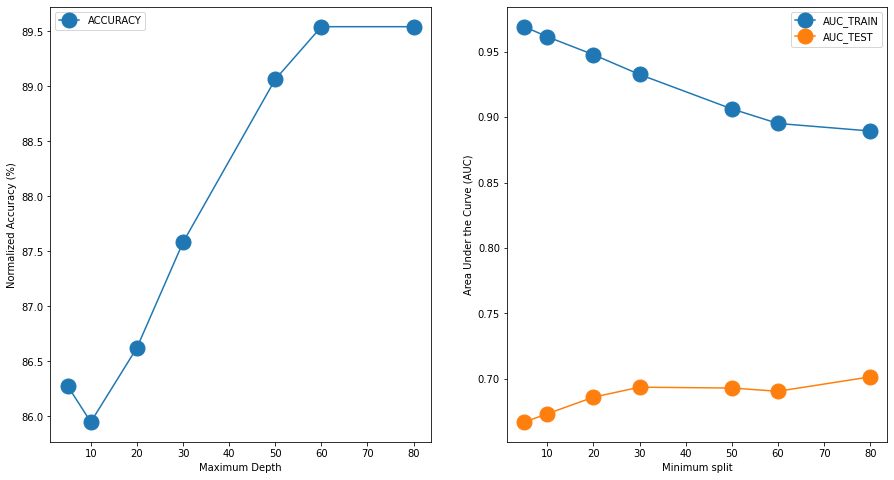

In [42]:
fig_1 = plt.figure(figsize=(15,8))

fig_1_a = plt.subplot(121)
ax1 = performance_df.plot(x = 'min_split', y = 'ACCURACY', ax = fig_1_a, style = 'o-', markersize =15)
ax1.set_ylabel("Normalized Accuracy (%)")
ax1.set_xlabel("Maximum Depth")

fig_1_b = plt.subplot(122)
ax2 = performance_df.plot(x = 'min_split', y = 'AUC_TRAIN', ax = fig_1_b, style = 'o-', markersize =15)
ax2 = performance_df.plot(x = 'min_split', y = 'AUC_TEST', ax = fig_1_b, style = 'o-', markersize =15)
ax2.set_xlabel("Minimum split")
ax2.set_ylabel("Area Under the Curve (AUC)")
# ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

In conclusion, I choose min_split as 20, max depth of 11 for best model.

### 1.2.5. Plot coefficient values or feature importance.

In [43]:
estimator = DecisionTreeClassifier(criterion = 'gini',random_state=1147, max_depth = 11,min_samples_split=20)
model_dt  = estimator.fit(X_train_annual, y_train_annual)

In [44]:
# Calculate feature importances
importances = model_dt.feature_importances_
importances

array([0.0017183 , 0.05140178, 0.03338736, 0.02267932, 0.        ,
       0.        , 0.        , 0.        , 0.02979055, 0.        ,
       0.        , 0.0305581 , 0.        , 0.0098353 , 0.01012655,
       0.02989526, 0.        , 0.04048025, 0.01001922, 0.03116676,
       0.01561073, 0.02114962, 0.04374251, 0.01644905, 0.        ,
       0.        , 0.0271676 , 0.        , 0.01001922, 0.        ,
       0.00838806, 0.00514519, 0.12723147, 0.15552226, 0.04553108,
       0.03643864, 0.00511464, 0.        , 0.        , 0.        ,
       0.        , 0.00506247, 0.01257163, 0.        , 0.        ,
       0.01221899, 0.        , 0.        , 0.04075503, 0.01036495,
       0.        , 0.        , 0.01490782, 0.        , 0.        ,
       0.00552309, 0.        , 0.        , 0.01102114, 0.00878863,
       0.        , 0.00585658, 0.        , 0.        , 0.01766373,
       0.02116496, 0.        , 0.00229244, 0.        , 0.        ,
       0.        , 0.        , 0.00973014, 0.        , 0.00350

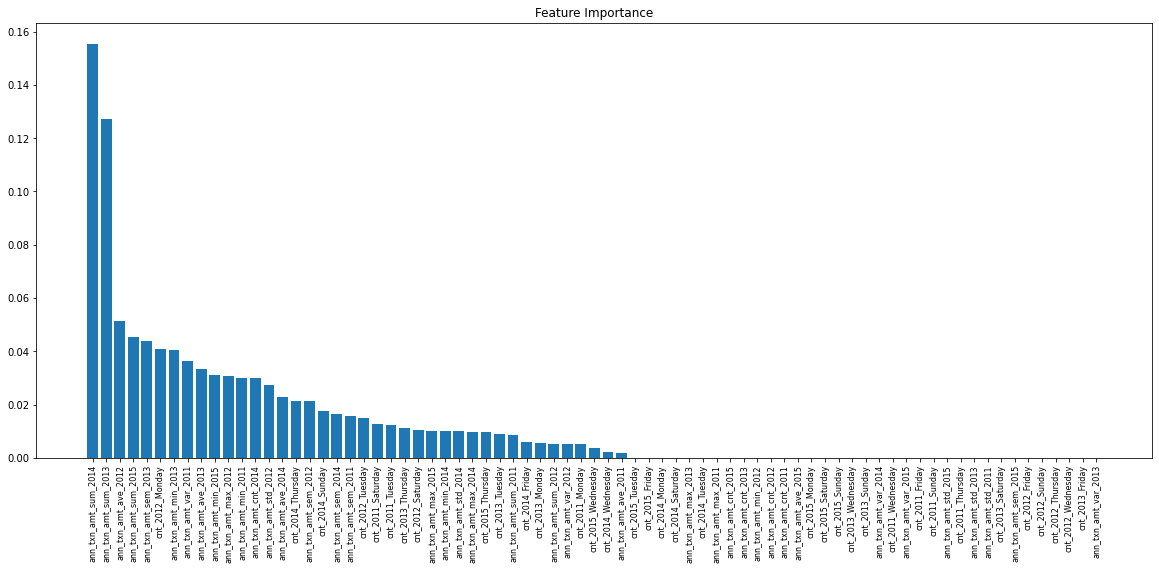

In [45]:
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X_annual.columns[i] for i in indices]

# Create plot
plt.figure(figsize=(20, 8))
# Create plot title
plt.title("Feature Importance")
# Add bars
plt.bar(range(X_annual.shape[1]), importances[indices])
# Add feature names as x-axis labels
plt.xticks(range(X_annual.shape[1]), names, rotation=90,size=8)
# Show plot
plt.show()

Here we can see that two of them has significant effect on decision tree performance, the others has importance less than 0.05.

### 1.2.6. Plot probability distribution for test set.

In [46]:
y_test_proba = model_dt.predict_proba(X_test_annual)
# y_test_proba = np.round(y_test_proba,2)

In [47]:
# How many different probabilities of defaulting are there and how many clients in each?
unique_elements, counts_elements = np.unique(y_test_proba[:,1], return_counts=True)
print("Frequency of unique values of the said array:")
print(unique_elements)
print(counts_elements)

Frequency of unique values of the said array:
[0.         0.00888889 0.02040816 0.02232143 0.03333333 0.04444444
 0.0625     0.10384615 0.10526316 0.15384615 0.16       0.1875
 0.2        0.21052632 0.22222222 0.25       0.33333333 0.4
 0.5        0.58333333 0.6        0.63636364 0.66666667 0.69230769
 0.75       1.        ]
[2099  467   88  390   86   86  119  560   48   19   65   41    6   37
   27   17   38    4   96   36    4   20    8   68   47  114]


Text(0, 0.5, 'Counts of clients')

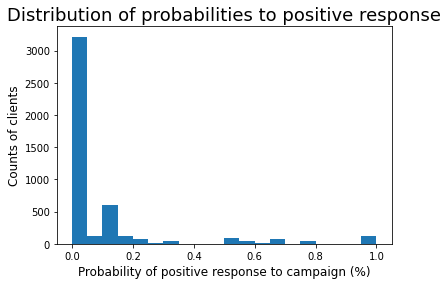

In [48]:
# plt.figure()
# sns.displot(data = y_test_proba[:,1], x = 100 * y_test_proba[:,1])
plt.hist(y_test_proba[:,1],bins=20)
plt.title('Distribution of probabilities to positive response',size=18)
plt.xlabel('Probability of positive response to campaign (%)',size=12)
plt.ylabel('Counts of clients',size=12)

Most samples in test dataset has low probability (less than 0.2) to respond positively to the promotional campaign, while very few of them has high probability, so the distribution of probability of clients is right skewed.

### 7. Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall.

In [49]:
y_test_predicted = model_dt.predict(X_test_annual)
cmt = confusion_matrix(y_test_annual, y_test_predicted)
print(cmt)

[[3909  230]
 [ 384   67]]


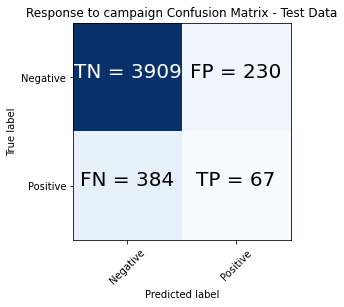

In [50]:
plt.clf()
plt.imshow(cmt, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
plt.title('Response to campaign Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
thresh = cmt.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cmt[i][j]), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cmt[i, j] > thresh else "black")
plt.show()

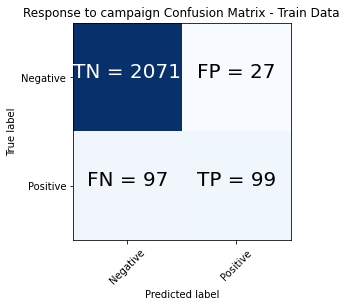

In [51]:
y_train_predicted = model_dt.predict(X_train_annual)
cmtr = confusion_matrix(y_train_annual, y_train_predicted)

plt.clf()
plt.imshow(cmtr, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
plt.title('Response to campaign Confusion Matrix - Train Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
thresh = cmtr.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cmtr[i][j]), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cmtr[i, j] > thresh else "black")
plt.show()

ROC curve

In [52]:
# Scores for train set
scores_train = model_dt.predict_proba(X_train_annual)[:, 1]
# Scores for test set
scores_test = model_dt.predict_proba(X_test_annual)[:, 1]

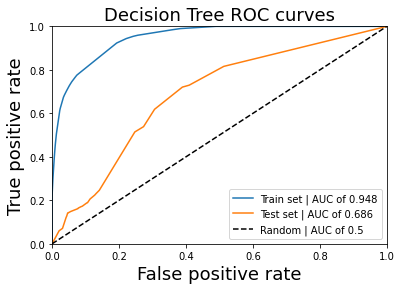

In [53]:
# ROC Calc Train set
fpr_train, tpr_train, _ = roc_curve(y_train_annual, scores_train)
# ROC Calc Test set
fpr_test, tpr_test, _ = roc_curve(y_test_annual, scores_test)
# AUC Calc
auc_train = auc(fpr_train, tpr_train)
# AUC Calc
auc_test  = auc(fpr_test, tpr_test)

# Plotting
plt.plot(fpr_train, tpr_train, label='Train set | AUC of {:4.3f}'.format(auc_train));
plt.plot(fpr_test, tpr_test, label='Test set | AUC of {:4.3f}'.format(auc_test));
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5');
plt.ylim([0,1.0])
plt.xlim([0,1.0])
plt.title('Decision Tree ROC curves', fontsize = 18)
plt.ylabel('True positive rate', fontsize = 18)
plt.xlabel('False positive rate', fontsize = 18)
plt.legend()
plt.show()

Calculate precision/recall

In [54]:
print(classification_report(y_test_annual, y_test_predicted, target_names = ['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.91      0.94      0.93      4139
    Positive       0.23      0.15      0.18       451

    accuracy                           0.87      4590
   macro avg       0.57      0.55      0.55      4590
weighted avg       0.84      0.87      0.85      4590



### 1.2.8. Plot decision boundary for top 2 features.

From the feature importance plot, we can observe that the top 2 features are ann_txn_amt_sum_2014 & 2013.

Then we confirm that ann_txn_amt_sum_2014, index=33, has min=0, max=974

ann_txn_amt_sum_2014, index=32, has min=0, max=1317

In [55]:
# min_max = pd.DataFrame(np.stack((Xs_train_monthly.min(axis=0),Xs_train_monthly.max(axis=0))), columns=X_monthly.columns)
# # np.stack((Xs_train_annual.min(axis=0),Xs_train_annual.max(axis=0)))
print(X_train_annual.columns[33])
print(X_train_annual.columns[32])
print(X_train_annual.min(axis=0).values[33])
print(X_train_annual.max(axis=0).values[33])
print(X_train_annual.min(axis=0).values[32])
print(X_train_annual.max(axis=0).values[32])
# print(min_max.amt_sum_12M.values)
# print(min_max.amt_mean_12M.values)

ann_txn_amt_sum_2014
ann_txn_amt_sum_2013
0.0
974.0
0.0
1317.0


In [56]:
xx, yy = np.mgrid[0:974:108, 0:1317:146] # The steps 1.1111 and 1.75 were selected to create a 10x10 grid
grid = np.c_[xx.ravel(), yy.ravel()]
print(grid.shape) # Confirm that grid shape is 10x10

# np.ones is a table full of ones with 100x75 dimension
# np.median calculates the median of every column in the X_train along axis=0 (i.e. column)
median_inputs = np.ones((100, 75)) * np.median(X_train_annual, axis=0) 
pd.DataFrame(median_inputs) # Convert to pandas is not necessary. Just doing it here to have a nice view of the table

# Then, we replace the 5th and 11th column with the values of the grid
median_inputs[:,33] = grid[:,0]
median_inputs[:,32] = grid[:,1]
df = pd.DataFrame(median_inputs).iloc[:13,30:35] # Convert to pandas is not necessary. Just doing it here to have a nice view of the table
df.style.apply(lambda x: ['background: grey' if (x.name == 32)|(x.name == 33)  else '' for i in x])


(100, 2)


,30,31,32,33,34
0,172.000000,283.000000,0.000000,0.000000,48.000000
1,172.000000,283.000000,146.000000,0.000000,48.000000
2,172.000000,283.000000,292.000000,0.000000,48.000000
3,172.000000,283.000000,438.000000,0.000000,48.000000
4,172.000000,283.000000,584.000000,0.000000,48.000000
5,172.000000,283.000000,730.000000,0.000000,48.000000
6,172.000000,283.000000,876.000000,0.000000,48.000000
7,172.000000,283.000000,1022.000000,0.000000,48.000000
8,172.000000,283.000000,1168.000000,0.000000,48.000000
9,172.000000,283.000000,1314.000000,0.000000,48.000000


In [57]:
probs = model_dt.predict_proba(median_inputs)[:, 1].reshape(xx.shape)

/Users/tongfeili/Library/Python/3.7/lib/python/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"


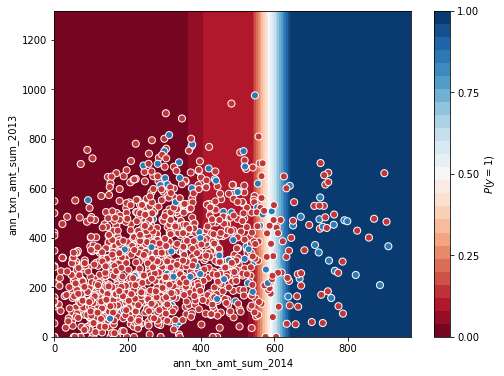

In [58]:
f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X_train_annual['ann_txn_amt_sum_2014'][1000:], X_train_annual['ann_txn_amt_sum_2013'][1000:], c=y_train_annual[1000:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)
# plt.annotate('Node #6 \n P(default) = 69.9%', xy=(5,1), xycoords='data',horizontalalignment= 'center', fontsize = 14)
# plt.annotate('Node #2 \n P = 15.0%', xy=(-0.5,0.5), xycoords='data',horizontalalignment= 'center', fontsize = 14)
# plt.annotate('Node #5 \n P = 43.1%', xy=(-0.5,6.0), xycoords='data',horizontalalignment= 'center', fontsize = 14)

ax.set(aspect="auto",
       xlim=(0, 974), ylim=(0, 1317),
       xlabel="ann_txn_amt_sum_2014", ylabel="ann_txn_amt_sum_2013")
plt.show()

## Annual Features -- Random Forest

### 1.2.4. Fit the training dataset and optimize the hyperparameters of the method.

 **max_features:** The number of features each tree considers at a split. Default value is: $\sqrt{n_{features}}$, which means $\sqrt{75}\approx7%$

In [59]:
from sklearn.ensemble import RandomForestClassifier
# Initiate some parameters that I want to track in the iteration below
max_depth_range = range(2, 15)
estimator_max_depth = []
accuracy_normalized = []
auc_train           = []
auc_test            = []
f1_test             = []
f1_train            = []

for i in max_depth_range:
    # Define and fit
    estimator_max_depth.append(RandomForestClassifier(n_estimators = 200, max_depth = i, random_state=1147))
    estimator_max_depth[i-2].fit(X_train_annual, y_train_annual)
    # Score train and test set ############### we don't need to store this in every iteration so we can overwrite it ###############
    scores_train = estimator_max_depth[i-2].predict_proba(X_train_annual)[:,1] 
    scores_test  = estimator_max_depth[i-2].predict_proba(X_test_annual)[:,1]  
    # Predict the class of test & train set
    y_test_predicted = estimator_max_depth[i-2].predict(X_test_annual)
    y_train_predicted = estimator_max_depth[i-2].predict(X_train_annual)
    # Calculate accuracy at every iteration and append
    accuracy_normalized.append(100*accuracy_score(y_test_annual, y_test_predicted, normalize = True))
    # ROC Calc Train set ############### we don't need to store this in every iteration so we can overwrite it ###############
    fpr_train, tpr_train, _ = roc_curve(y_train_annual, scores_train)
    # ROC Calc Test set ############### we don't need to store this in every iteration so we can overwrite it ###############
    fpr_test, tpr_test, _ = roc_curve(y_test_annual, scores_test)
    # Calculate the AUCs
    auc_train.append(auc(fpr_train, tpr_train))
    auc_test.append(auc(fpr_test, tpr_test))
    # Calculate F1
    f1_test.append(100*f1_score(y_test_annual, y_test_predicted))
    f1_train.append(100*f1_score(y_train_annual, y_train_predicted))

In [60]:
performance_dictionary = {'ACCURACY': accuracy_normalized, 
                          'AUC_TRAIN': auc_train,
                          'AUC_TEST': auc_test,
                          'F1_TEST': f1_test,
                          'F1_TRAIN': f1_train}
performance_df = pd.DataFrame(performance_dictionary)
performance_df['MAX_DEPTH'] = performance_df.index + 2
performance_df

,ACCURACY,AUC_TRAIN,AUC_TEST,F1_TEST,F1_TRAIN,MAX_DEPTH
0,90.174292,0.811188,0.749183,0.000000,0.000000,2
1,90.174292,0.849582,0.751567,0.000000,0.000000,3
2,90.174292,0.894440,0.750061,0.000000,0.000000,4
3,90.174292,0.938831,0.747521,0.000000,0.000000,5
4,90.174292,0.975677,0.747849,0.000000,3.015075,6
5,90.174292,0.993456,0.746407,0.000000,11.538462,7
6,90.174292,0.998915,0.739210,0.000000,26.548673,8
7,90.174292,0.999956,0.731557,0.000000,45.669291,9
8,90.174292,1.000000,0.731662,0.000000,62.937063,10
9,90.196078,1.000000,0.723754,0.442478,80.487805,11


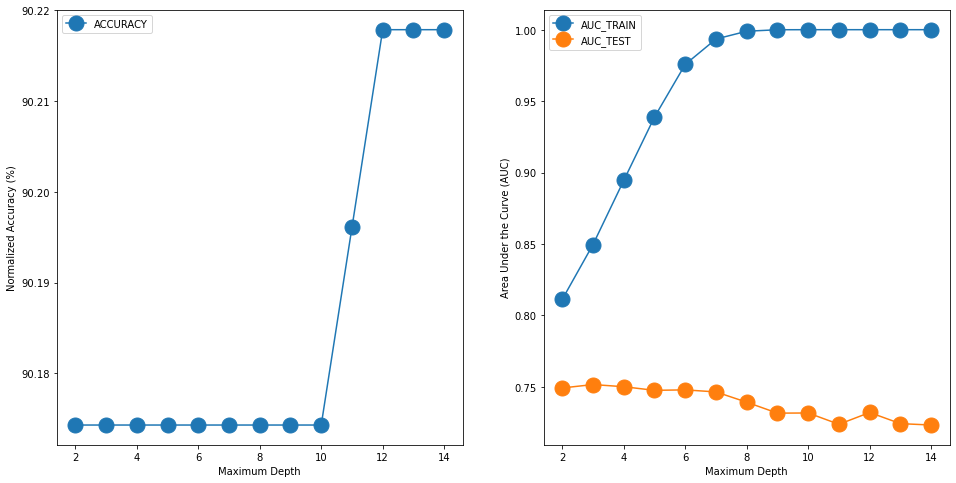

In [61]:
fig_1 = plt.figure(figsize=(16,8))

fig_1_a = plt.subplot(121)
ax1 = performance_df.plot(x = 'MAX_DEPTH', y = 'ACCURACY', ax = fig_1_a, style = 'o-', markersize =15)
ax1.set_ylabel("Normalized Accuracy (%)")
ax1.set_xlabel("Maximum Depth")

fig_1_b = plt.subplot(122)
ax2 = performance_df.plot(x = 'MAX_DEPTH', y = 'AUC_TRAIN', ax = fig_1_b, style = 'o-', markersize =15)
ax2 = performance_df.plot(x = 'MAX_DEPTH', y = 'AUC_TEST', ax = fig_1_b, style = 'o-', markersize =15)
ax2.set_xlabel("Maximum Depth")
ax2.set_ylabel("Area Under the Curve (AUC)")
# ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

Increase of max_depth here does not lead to significant increase in AUC test, AUC train or acccuracy here, instead F1 value increased significantly to 0.88 at depth=12 in this case. I choose max_depth=12 here.

In [62]:
# Define and fit
estimator = RandomForestClassifier(random_state=1147, max_depth = 12)
rf_best_model = estimator.fit(X_train_annual, y_train_annual)
# Score train and test set ############### we don't need to store this in every iteration so we can overwrite it ###############
scores_train = rf_best_model.predict_proba(X_train_annual)[:,1] 
scores_test  = rf_best_model.predict_proba(X_test_annual)[:,1]  
# Predict the class of test set
y_test_predicted = rf_best_model.predict(X_test_annual)
# Calculate accuracy at every iteration and append
accuracy = 100*accuracy_score(y_test_annual, y_test_predicted, normalize = True)
# ROC Calc Train set 
fpr_train, tpr_train, _ = roc_curve(y_train_annual, scores_train)
# ROC Calc Test set
fpr_test, tpr_test, _ = roc_curve(y_test_annual, scores_test)
# Calculate the AUCs
auc_train = auc(fpr_train, tpr_train)
auc_test  = auc(fpr_test, tpr_test)

### 1.2.5. Plot coefficient values or feature importance.

In [63]:
# Calculate feature importances
importances = rf_best_model.feature_importances_
print(importances)
print(importances.shape)

[0.02190069 0.02027236 0.02670438 0.02559778 0.01363589 0.00908132
 0.01106419 0.01960296 0.03332221 0.0058336  0.01707476 0.01820189
 0.02071102 0.01988399 0.01133113 0.02175621 0.01570863 0.01745727
 0.0161425  0.01186744 0.01880393 0.02140526 0.02526307 0.0203951
 0.00467998 0.01892482 0.02150296 0.02242034 0.02122362 0.00588211
 0.02153972 0.01985166 0.04359044 0.05422268 0.0160041  0.01655796
 0.02166302 0.02004126 0.02113683 0.00660799 0.00530569 0.00677017
 0.00779472 0.00502291 0.00455271 0.00590787 0.00504754 0.00726019
 0.00820747 0.00553403 0.00654249 0.00422533 0.00824649 0.00654747
 0.00596365 0.00786661 0.00737304 0.01021168 0.01211334 0.00734786
 0.00578111 0.00707676 0.00756736 0.00738868 0.01078489 0.00869998
 0.00786735 0.01133485 0.00164686 0.00311527 0.00231483 0.00187243
 0.00290241 0.00186762 0.00307127]
(75,)


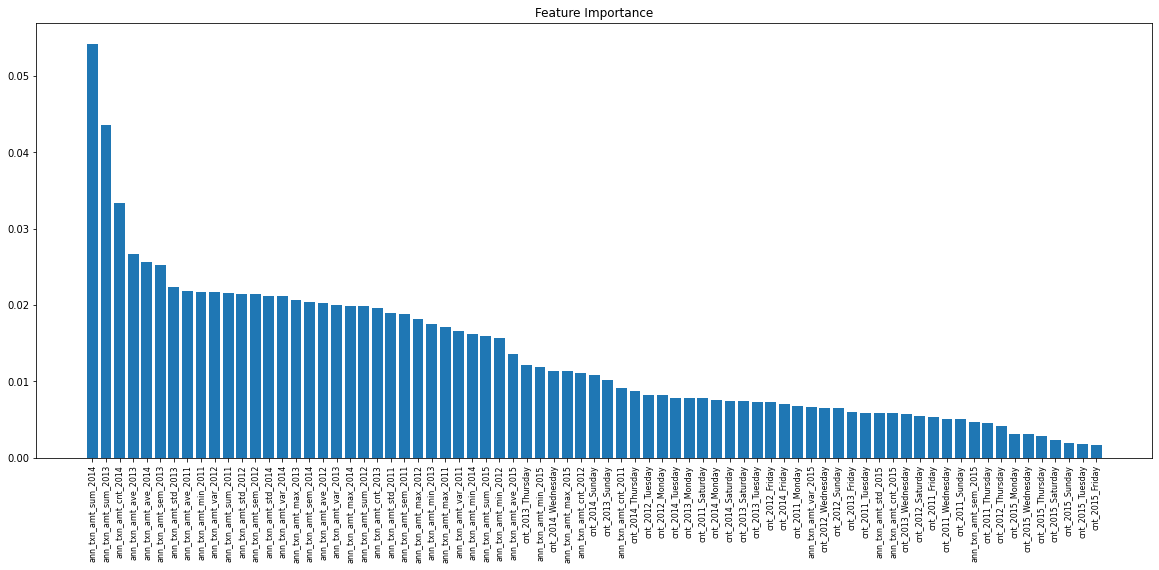

In [64]:
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X_annual.columns[i] for i in indices]

# Create plot
plt.figure(figsize=(20,8))
# Create plot title
plt.title("Feature Importance")
# Add bars
plt.bar(range(X_annual.shape[1]), importances[indices])
# Add feature names as x-axis labels
plt.xticks(range(X_annual.shape[1]), names, rotation=90,size=8)
# Show plot
plt.show()

Here, we can see that the two most important feature is ann_txn_amt_sum_2014 & ann_txn_amt_sum_2013.

### 1.2.6. Plot probability distribution for test set.

Text(0, 0.5, 'Counts of clients')

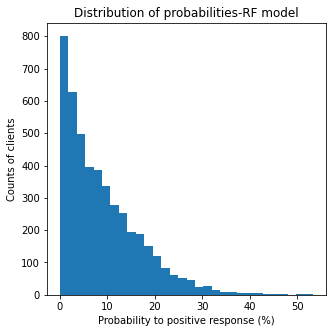

In [65]:
plt.figure(figsize=(5,5))
# sns.displot(data = scores_test, x = 100*scores_test)
plt.hist(100*scores_test,bins=30)
plt.title('Distribution of probabilities-RF model')
plt.xlabel('Probability to positive response (%)')
plt.ylabel('Counts of clients')

### 1.2.7.  Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall.


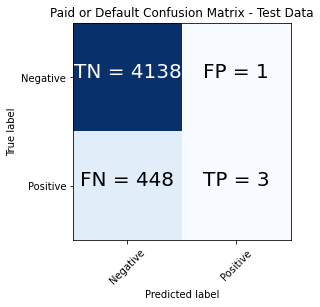

In [66]:
cm = confusion_matrix(y_test_annual, y_test_predicted)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
plt.title('Paid or Default Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.show()

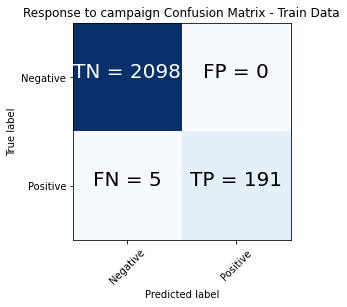

In [67]:
cm = confusion_matrix(y_train_annual, y_train_predicted)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
plt.title('Response to campaign Confusion Matrix - Train Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.show()

ROC curve

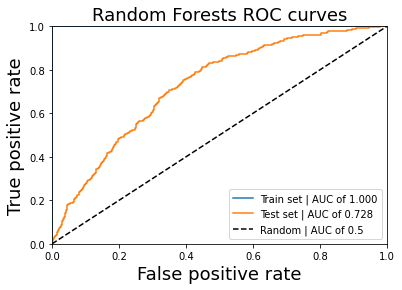

In [68]:
plt.plot(fpr_train, tpr_train, label='Train set | AUC of {:4.3f}'.format(auc_train));
plt.plot(fpr_test, tpr_test, label='Test set | AUC of {:4.3f}'.format(auc_test));
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5');
plt.ylim([0,1.0])
plt.xlim([0,1.0])
plt.title('Random Forests ROC curves', fontsize = 18)
plt.ylabel('True positive rate', fontsize = 18)
plt.xlabel('False positive rate', fontsize = 18)
plt.legend()
plt.show()

Calculate precision/recall

In [69]:
print(classification_report(y_test_annual, y_test_predicted, target_names = ['Negetive', 'Positive']))

              precision    recall  f1-score   support

    Negetive       0.90      1.00      0.95      4139
    Positive       0.75      0.01      0.01       451

    accuracy                           0.90      4590
   macro avg       0.83      0.50      0.48      4590
weighted avg       0.89      0.90      0.86      4590



### 1.2.8. Plot decision boundary for top 2 features.

In [70]:
# confirm ann_txn_amt_sum_2014 has index 33, min=0, max=974
# confirm ann_txn_amt_sum_2013 has index 32, min=0, max=1317
print(X_train_annual.columns[33])
print(X_train_annual.columns[32])
print(X_train_annual.min(axis=0).values[33])
print(X_train_annual.max(axis=0).values[33])
print(X_train_annual.min(axis=0).values[32])
print(X_train_annual.max(axis=0).values[32])

ann_txn_amt_sum_2014
ann_txn_amt_sum_2013
0.0
974.0
0.0
1317.0


In [71]:
xx, yy = np.mgrid[0:974:108.22, 0:1317:146.33] # The steps 1.1111 and 1.75 were selected to create a 10x10 grid
grid = np.c_[xx.ravel(), yy.ravel()]
print(grid.shape) # Confirm that grid shape is 10x10

# np.ones is a table full of ones with 100x23 dimension
# np.median calculates the median of every column in the X_train along axis=0 (i.e. column)
median_inputs = np.ones((100, 75)) * np.median(X_train_annual, axis=0) 
pd.DataFrame(median_inputs) # Convert to pandas is not necessary. Just doing it here to have a nice view of the table

# Then, we replace the 5th and 11th column with the values of the grid
median_inputs[:,33] = grid[:,0]
median_inputs[:,32] = grid[:,1]
df = pd.DataFrame(median_inputs).iloc[:13,30:35] # Convert to pandas is not necessary. Just doing it here to have a nice view of the table
df.style.apply(lambda x: ['background: grey' if (x.name == 32)|(x.name == 33)  else '' for i in x])



(100, 2)


,30,31,32,33,34
0,172.000000,283.000000,0.000000,0.000000,48.000000
1,172.000000,283.000000,146.330000,0.000000,48.000000
2,172.000000,283.000000,292.660000,0.000000,48.000000
3,172.000000,283.000000,438.990000,0.000000,48.000000
4,172.000000,283.000000,585.320000,0.000000,48.000000
5,172.000000,283.000000,731.650000,0.000000,48.000000
6,172.000000,283.000000,877.980000,0.000000,48.000000
7,172.000000,283.000000,1024.310000,0.000000,48.000000
8,172.000000,283.000000,1170.640000,0.000000,48.000000
9,172.000000,283.000000,1316.970000,0.000000,48.000000


/Users/tongfeili/Library/Python/3.7/lib/python/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


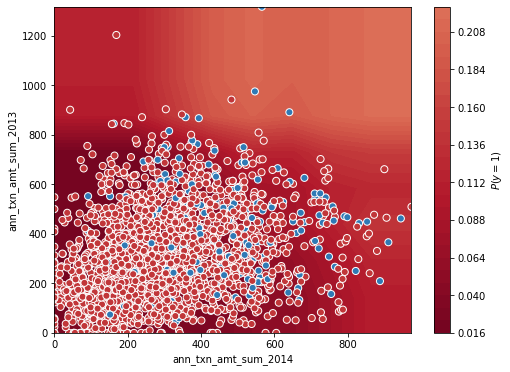

In [72]:
probs = rf_best_model.predict_proba(median_inputs)[:, 1].reshape(xx.shape)
f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
# ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X_train_annual['ann_txn_amt_sum_2014'][50:], X_train_annual['ann_txn_amt_sum_2013'][50:], c=y_train_annual[50:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)
# plt.annotate('P = 45.0%', xy=(5,0), xycoords='data',horizontalalignment= 'center', verticalalignment= 'center', fontsize = 14)
# plt.annotate('P = 12.8%', xy=(-0.8,0.35), xycoords='data', horizontalalignment= 'center', fontsize = 14)
# plt.annotate('P = 27.2%', xy=(-0.8,6.0), xycoords='data', horizontalalignment= 'center', verticalalignment= 'center', fontsize = 14)
# plt.annotate('P = 55.1%', xy=(6.0,3.0), xycoords='data', horizontalalignment= 'center', verticalalignment= 'center', fontsize = 14)
# plt.annotate('P = 27.2%', xy=(7.0,4.5), xycoords='data', horizontalalignment= 'center', verticalalignment= 'center', fontsize = 14)

ax.set(aspect="auto",
       xlim=(0, 974), ylim=(0, 1317),
       xlabel="ann_txn_amt_sum_2014", ylabel="ann_txn_amt_sum_2013")
plt.show()

## Monthly Features -- LR with L1 regularization

### 1.2.1. Separate the inputs X and the output y in two data frames.

In [73]:
X_monthly = monthly_features_outputs.drop(columns=['response','customer_id','ME_DT'])
y_monthly = monthly_features_outputs.response
X_monthly = X_monthly.fillna(0)
X_monthly

,days_since_last_txn,cnt_Friday,cnt_Monday,cnt_Saturday,cnt_Sunday,cnt_Thursday,cnt_Tuesday,cnt_Wednesday,mth_txn_amt_sum,mth_txn_cnt,...,amt_max_6M,txn_cnt_sum_6M,txn_cnt_mean_6M,txn_cnt_max_6M,amt_sum_12M,amt_mean_12M,amt_max_12M,txn_cnt_sum_12M,txn_cnt_mean_12M,txn_cnt_max_12M
0,-1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
1,15,0,0,0,0,0,0,1,56,1,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
2,46,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
3,12,1,0,0,0,0,0,0,96,1,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
4,42,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323543,98,0,0,0,0,0,0,0,0,0,...,35.0,2.0,0.333333,1.0,97.0,8.083333,35.0,4.0,0.333333,1.0
323544,129,0,0,0,0,0,0,0,0,0,...,35.0,2.0,0.333333,1.0,97.0,8.083333,35.0,4.0,0.333333,1.0
323545,160,0,0,0,0,0,0,0,0,0,...,35.0,1.0,0.166667,1.0,81.0,6.750000,35.0,3.0,0.250000,1.0
323546,0,0,0,1,0,0,0,0,34,1,...,34.0,1.0,0.166667,1.0,115.0,9.583333,35.0,4.0,0.333333,1.0


### 1.2.2. Split the data in train and test set.

In [74]:
X_train_monthly, X_test_monthly, y_train_monthly, y_test_monthly = train_test_split(
    X_monthly, y_monthly, test_size=2/3, random_state=1147)
# X_train_monthly 107849 * 29
# X_test_monthly 215699 rows × 29 columns

### 1.2.3. Pre-process (if necessary for the method).

Here I standardized the X training and test data

In [75]:
scaler = StandardScaler()
Xs_train_monthly = scaler.fit_transform(X_train_monthly)
Xs_test_monthly = scaler.transform(X_test_monthly)

### 1.2.4. Fit the training dataset and optimize the hyperparameters of the method.

In [76]:
# ===================================== #
# === [Sklearn Model Configuration] === #
# ===================================== #

C = np.linspace(0.001, 0.5, 20)
# Smaller values, stronger regularization, more coefficients will go to zero

# Initialize the variables you want to save in an iterative manner
count                     = -1
Train_AUC_iter_LR         = np.zeros(shape=(len(C),1))
Test_AUC_iter_LR          = np.zeros(shape=(len(C),1))
NonZeroCoeff_LR           = np.zeros(shape=(len(C),1))
Model_Coeff_LR            = np.zeros(shape=(X_monthly.shape[1], len(C)))
Train_accuracy_iter_LR    = np.zeros(shape=(len(C),1))
Test_accuracy_iter_LR    = np.zeros(shape=(len(C),1))


fig = plt.figure(figsize=(16, 16))

for c in C:
    count += 1
    # instantiate a logistic regression model, and fit with X and y
    model_LR = LogisticRegression(C=c, penalty='l1', solver="liblinear",random_state=1147)
    # Fit the model
    model_LR.fit(Xs_train_monthly, y_train_monthly)
    Model_Coeff_LR[:,count] = model_LR.coef_[0,:]
    # Scores for train set
    scores_train_LR = model_LR.predict_proba(Xs_train_monthly)[:, 1]
    # Scores for test set
    scores_test_LR = model_LR.predict_proba(Xs_test_monthly)[:, 1]
    # predict the class
    y_train_monthly_predicted = model_LR.predict(Xs_train_monthly)
    y_test_monthly_predicted = model_LR.predict(Xs_test_monthly)
    
    # ============================ #
    # === [Train: ROC and AUC] === #
    # ============================ #
    # ROC Calc
    fpr_train_LR, tpr_train_LR, _ = roc_curve(y_train_monthly, scores_train_LR)
    # AUC Calc
    auc_train_LR = auc(fpr_train_LR, tpr_train_LR)
    Train_AUC_iter_LR[count,0] = auc_train_LR
    # ============================ #
    # === [Test: ROC and AUC] === #
    # ============================ #
    # ROC Calc
    fpr_test_LR, tpr_test_LR, _ = roc_curve(y_test_monthly, scores_test_LR)
    # AUC Calc
    auc_test_LR = auc(fpr_test_LR, tpr_test_LR)
    Test_AUC_iter_LR[count,0] = auc_test_LR
    ### Extract the count of non-zero coefficients
    NonZeroCoeff_LR[count,0] = X_monthly.shape[1] - (model_LR.coef_ == 0).sum()
    
    ### Accuracy ###
    Train_accuracy_iter_LR[count,0]=(100*accuracy_score(y_train_monthly, y_train_monthly_predicted, normalize = True))
    Test_accuracy_iter_LR[count,0]=(100*accuracy_score(y_test_monthly, y_test_monthly_predicted, normalize = True))
    
    x = model_LR.coef_.transpose()   
    index = np.arange(len(x))  

<Figure size 1152x1152 with 0 Axes>

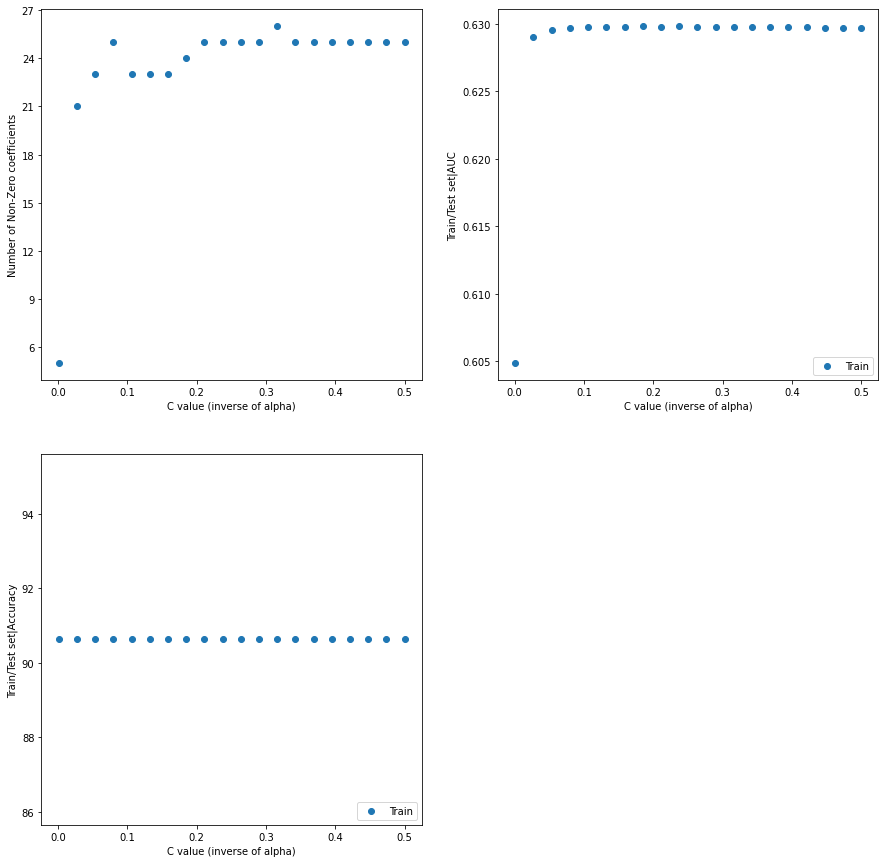

In [77]:
# Plot of the NonZero coefficients    
fig = plt.figure(figsize=(15, 15))
sub1 = fig.add_subplot(221)
plt.scatter(C, NonZeroCoeff_LR)
sub1.set_ylabel('Number of Non-Zero coefficients')
sub1.set_xlabel('C value (inverse of alpha)')
sub1.yaxis.set_major_locator(MaxNLocator(integer=True))
# sub1.set_xlim(0.01,1)
# plt.xscale('log')
# plt.show()

sub2 = fig.add_subplot(222)
plt.scatter(C,Train_AUC_iter_LR)
# plt.scatter(C,Test_AUC_iter_LR)
sub2.set_xlabel('C value (inverse of alpha)')
sub2.set_ylabel('Train/Test set|AUC')
# sub1.set_xlim(0.02,0.06)
# plt.annotate('AUC= %0.3f' %(Test_AUC_iter_LR[8]), xy=(C[8], 1.003*Test_AUC_iter_LR[8]), xycoords='data',horizontalalignment= 'left', fontsize = 12)
# plt.annotate('AUC= %0.3f' %(Train_AUC_iter_LR[8]), xy=(0.9*C[8], 1.003*Train_AUC_iter_LR[8]), xycoords='data',horizontalalignment= 'right', fontsize = 12)
plt.legend(['Train'], loc ='lower right')

sub3 = fig.add_subplot(223)
plt.scatter(C,Train_accuracy_iter_LR)
# plt.scatter(C,Test_accuracy_iter_LR)
sub3.set_xlabel('C value (inverse of alpha)')
sub3.set_ylabel('Train/Test set|Accuracy')
plt.legend(['Train'], loc ='lower right')
# plt.axhline(Test_AUC_iter_LR[8], color = 'k', linestyle = '--')
# plt.axvline(C[8], color = 'k', linestyle = '--')
# plt.plot([C[8],C[8]],[plt.ylim()[0],Test_AUC_iter_LR[8]])
# plt.xscale('log')

plt.show()

I would choose c=0.05 as best parameter here, since AUC tends to be in plautau after value of 0.05, accuracy for train and test are fairly high (more than 0.9), but AUC is low (less than 0.65) for any c value here.

In [78]:
# create and fit best model
model_LR_best = LogisticRegression(C=0.05, penalty='l1', solver="liblinear",random_state=1147)
# Fit the model
model_LR_best.fit(Xs_train_monthly, y_train_monthly)

LogisticRegression(C=0.05, penalty='l1', random_state=1147, solver='liblinear')

### 1.2.5. Plot coefficient values or feature importance

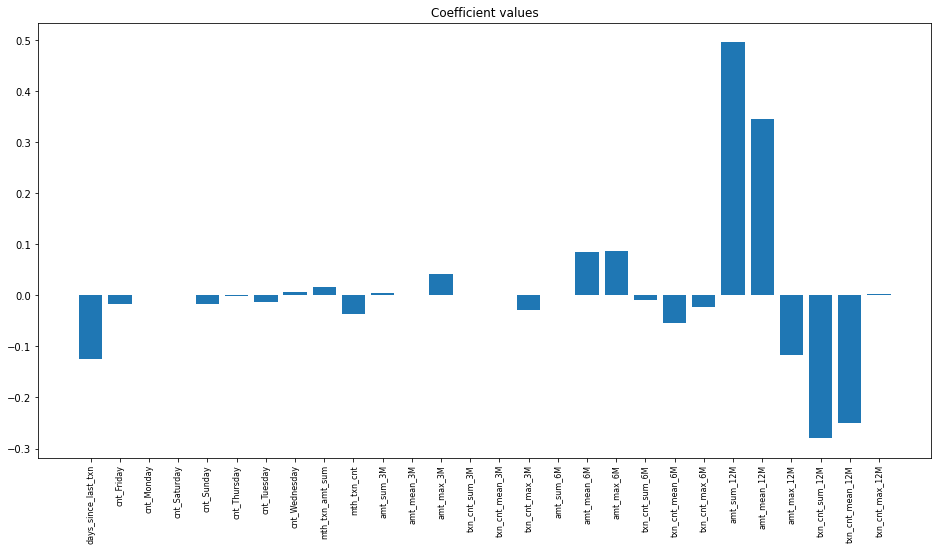

In [79]:
# coefficients
m = model_LR_best.coef_
# intercept
b = model_LR_best.intercept_

# Create plot
plt.figure(figsize=(16,8)) 
# Create plot title
plt.title("Coefficient values")
# Add bars
plt.bar(range(Xs_train_monthly.shape[1]), m[0])
# Add feature names as x-axis labels
plt.xticks(range(Xs_train_monthly.shape[1]), X_monthly.columns, rotation=90,size=8)
# Show plot
plt.show()

### 1.2.6. Plot probability distribution for test set.

In [80]:
# fit test set
y_test_proba = model_LR_best.predict_proba(Xs_test_monthly)
y_test_proba.shape

(215699, 2)

ValueError: Cannot mask with non-boolean array containing NA / NaN values

<Figure size 360x360 with 0 Axes>

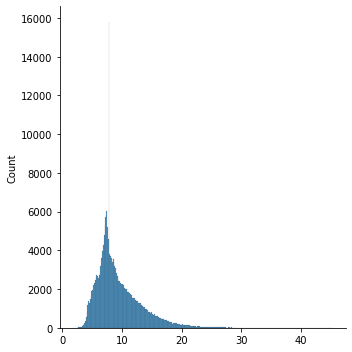

In [81]:
plt.figure(figsize=(5,5))
sns.displot(data = y_test_proba[:,1], x = 100*y_test_proba[:,1])
plt.title('Distribution of probabilities to positive response to campaign',size=18)
plt.xlabel('Probability positive response (%)',size=15)
plt.ylabel('Counts of clients',size=15)
plt.show()

Here, we can see the probability distribution is right skewed, most of the clients have low probability(around 10%) of positive resonse, very few people have more than 20% possibility of positive response. We may be able to assume that this L1 regression model is not a good fit for our monthly data, since all probability distributes on the left side.

### 1.2.7. Plot confusion matrix and ROC curves of train/test set.

In [82]:
from sklearn.metrics import confusion_matrix
y_train_predicted = model_LR_best.predict(Xs_train_monthly)
y_test_predicted = model_LR_best.predict(Xs_test_monthly)
cm_train = confusion_matrix(y_train_monthly, y_train_predicted)
cm_test = confusion_matrix(y_test_monthly, y_test_predicted)

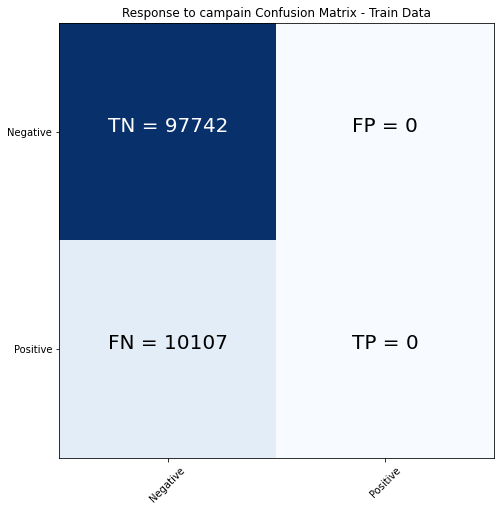

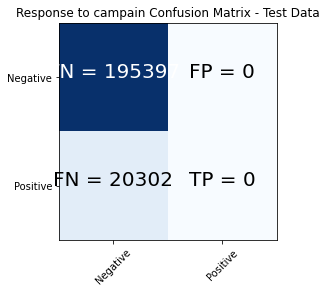

In [83]:
fig = plt.figure(figsize=(8,8))
sub1 = fig.add_subplot(121)
plt.clf()
plt.imshow(cm_train, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
plt.title('Response to campain Confusion Matrix - Train Data')
sub1.set_ylabel('True label')
sub1.set_xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm_train.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm_train[i][j]), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm_train[i, j] > thresh else "black")

plt.show()
        
sub2 = fig.add_subplot(122)        
plt.clf()
plt.imshow(cm_test, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
plt.title('Response to campain Confusion Matrix - Test Data')
sub2.set_ylabel('True label')
sub2.set_xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm_test.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm_test[i][j]), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm_test[i, j] > thresh else "black")

plt.show()

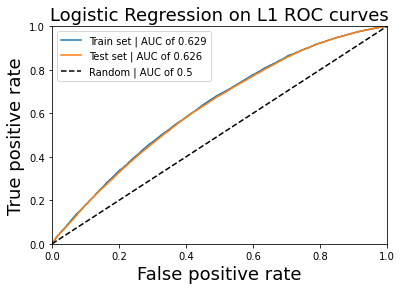

In [84]:
# Scores for train set
scores_train = model_LR_best.predict_proba(Xs_train_monthly)[:, 1]
# Scores for test set
scores_test = model_LR_best.predict_proba(Xs_test_monthly)[:, 1]

# ROC Calc Train set
fpr_train, tpr_train, _ = roc_curve(y_train_monthly, scores_train)
# ROC Calc Test set
fpr_test, tpr_test, _ = roc_curve(y_test_monthly, scores_test)
# AUC Calc
auc_train = auc(fpr_train, tpr_train)
# AUC Calc
auc_test  = auc(fpr_test, tpr_test)

# Plotting
plt.plot(fpr_train, tpr_train, label='Train set | AUC of {:4.3f}'.format(auc_train));
plt.plot(fpr_test, tpr_test, label='Test set | AUC of {:4.3f}'.format(auc_test));
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5');
plt.ylim([0,1.0])
plt.xlim([0,1.0])
plt.title('Logistic Regression on L1 ROC curves', fontsize = 18)
plt.ylabel('True positive rate', fontsize = 18)
plt.xlabel('False positive rate', fontsize = 18)
plt.legend()
plt.show()

Calculate Precision/Recall

In [85]:
print('Precision/Recall for training set')
print(classification_report(y_train_monthly, y_train_predicted, target_names = ['Negative', 'Positive']))
print('---------------------------------------------------------')
print('Precision/Recall for test set')
print(classification_report(y_test_monthly, y_test_predicted, target_names = ['Negative', 'Positive']))

Precision/Recall for training set
              precision    recall  f1-score   support

    Negative       0.91      1.00      0.95     97742
    Positive       0.00      0.00      0.00     10107

    accuracy                           0.91    107849
   macro avg       0.45      0.50      0.48    107849
weighted avg       0.82      0.91      0.86    107849

---------------------------------------------------------
Precision/Recall for test set
              precision    recall  f1-score   support

    Negative       0.91      1.00      0.95    195397
    Positive       0.00      0.00      0.00     20302

    accuracy                           0.91    215699
   macro avg       0.45      0.50      0.48    215699
weighted avg       0.82      0.91      0.86    215699



/Users/tongfeili/Library/Python/3.7/lib/python/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tongfeili/Library/Python/3.7/lib/python/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tongfeili/Library/Python/3.7/lib/python/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

### 1.2.8. Plot decision boundary for top 2 features.

From the coefficient value plot, we can see that the top 2 features are amt_sum_12M and amt_mean_12M.

In [86]:
min_max = pd.DataFrame(np.stack((Xs_train_monthly.min(axis=0),Xs_train_monthly.max(axis=0))), columns=X_monthly.columns)
# np.stack((Xs_train_annual.min(axis=0),Xs_train_annual.max(axis=0)))
print(min_max.amt_sum_12M.values)
print(min_max.amt_mean_12M.values)

[-1.16581794  4.86271442]
[-1.16581794  4.86271442]


In [87]:
xx, yy = np.mgrid[-1.2:5:0.68, -1.2:5:0.68] # The steps 1.1111 and 1.75 were selected to create a 10x10 grid
grid = np.c_[xx.ravel(), yy.ravel()]
grid.shape # Confirm that grid shape is 10x10

(100, 2)

In [88]:
# np.ones is a table full of ones with 100x23 dimension
# np.median calculates the median of every column in the X_train along axis=0 (i.e. column)
median_inputs = np.ones((100, 28)) * np.median(Xs_train_monthly, axis=0) 
median_inputs = pd.DataFrame(median_inputs,columns=X_monthly.columns) 

# Then, we replace the amt_sum_12M & amt_mean_12M column with the values of the grid
median_inputs.amt_sum_12M = grid[:,0]
median_inputs.amt_mean_12M = grid[:,1]
median_inputs.amt_sum_12M
# df = pd.DataFrame(median_inputs).iloc[:13,:12] # Convert to pandas is not necessary. Just doing it here to have a nice view of the table
# df.style.apply(lambda x: ['background: grey' if (x.name == 5)|(x.name == 11)  else '' for i in x])

0    -1.20
1    -1.20
2    -1.20
3    -1.20
4    -1.20
      ... 
95    4.92
96    4.92
97    4.92
98    4.92
99    4.92
Name: amt_sum_12M, Length: 100, dtype: float64

In [89]:
median_inputs.iloc[:,23]

0    -1.20
1    -0.52
2     0.16
3     0.84
4     1.52
      ... 
95    2.20
96    2.88
97    3.56
98    4.24
99    4.92
Name: amt_mean_12M, Length: 100, dtype: float64

In [90]:
# Score the artificial data on the grid
probs = model_LR_best.predict_proba(median_inputs.values)[:, 1].reshape(xx.shape)

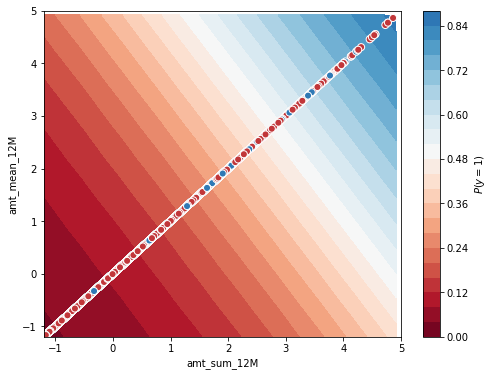

In [91]:
f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
# ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(Xs_train_monthly[:,22], Xs_train_monthly[:, 23], c=y_train_monthly[:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(aspect="auto",
       xlim=(-1.2,5), ylim=(-1.2,5),
       xlabel="amt_sum_12M", ylabel="amt_mean_12M")
plt.show()

## Monthly Features -- Decision Tree

### 1.2.3. Pre-process (if necessary for the method).

We don't need standardization for decision tree, because it is not a distance based analysis method.

### 1.2.4. Fit the training dataset and optimize the hyperparameters of the method.

In [92]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
# Initiate some parameters that I want to track in the iteration below
max_depth_range = range(1, 20)
estimator_max_depth = []
accuracy_normalized = []
auc_train           = []
auc_test            = []
f1_test             = []

for i in max_depth_range:
    # Define and fit
    estimator_max_depth.append(DecisionTreeClassifier(random_state=1147, max_depth = i))
    estimator_max_depth[i-1].fit(X_train_monthly, y_train_monthly)
    # Score train and test set ############### we don't need to store this in every iteration so we can overwrite it ###############
    scores_train = estimator_max_depth[i-1].predict_proba(X_train_monthly)[:,1] 
    scores_test  = estimator_max_depth[i-1].predict_proba(X_test_monthly)[:,1]  
    # Predict the class of test set
    y_test_predicted = estimator_max_depth[i-1].predict(X_test_monthly)
    # Calculate accuracy at every iteration and append
    accuracy_normalized.append(100*accuracy_score(y_test_monthly, y_test_predicted, normalize = True))
    # ROC Calc Train set ############### we don't need to store this in every iteration so we can overwrite it ###############
    fpr_train, tpr_train, _ = roc_curve(y_train_monthly, scores_train)
    # ROC Calc Test set ############### we don't need to store this in every iteration so we can overwrite it ###############
    fpr_test, tpr_test, _ = roc_curve(y_test_monthly, scores_test)
    # Calculate the AUCs
    auc_train.append(auc(fpr_train, tpr_train))
    auc_test.append(auc(fpr_test, tpr_test))
    # Calculate F1
    f1_test.append(f1_score(y_test_monthly, y_test_predicted)) 

In [93]:
performance_dictionary = {'ACCURACY': accuracy_normalized, 
                          'AUC_TRAIN': auc_train,
                          'AUC_TEST': auc_test,
                          'F1_Test': f1_test}
performance_df = pd.DataFrame(performance_dictionary)
performance_df['MAX_DEPTH'] = performance_df.index + 1
performance_df

,ACCURACY,AUC_TRAIN,AUC_TEST,F1_Test,MAX_DEPTH
0,90.587810,0.594127,0.588387,0.000000,1
1,90.587810,0.619378,0.614206,0.000000,2
2,90.587810,0.632740,0.628077,0.000000,3
3,90.586419,0.639305,0.633332,0.000098,4
4,90.573438,0.644058,0.635062,0.002747,5
5,90.574829,0.647919,0.635595,0.003334,6
6,90.542840,0.653900,0.634388,0.004490,7
7,90.521514,0.659656,0.635359,0.007283,8
8,90.467272,0.667261,0.634388,0.009728,9
9,90.432964,0.676914,0.633518,0.011970,10


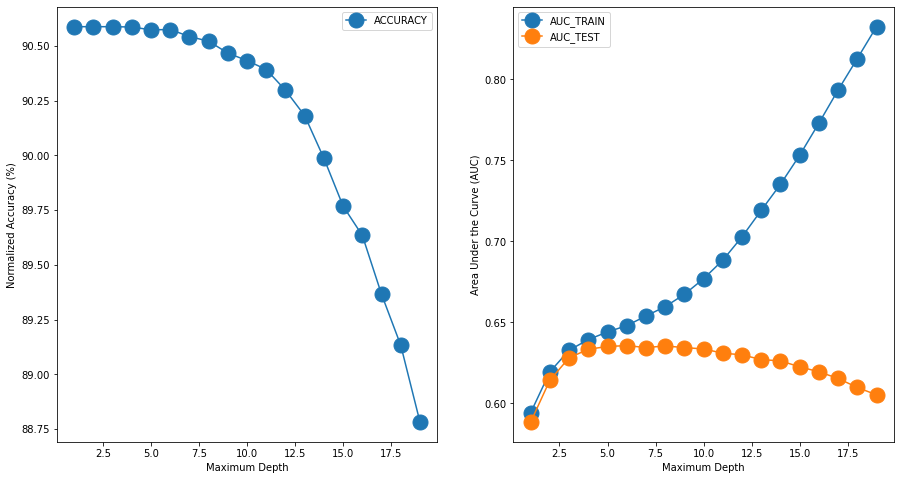

In [94]:
fig_1 = plt.figure(figsize=(15,8))

fig_1_a = plt.subplot(121)
ax1 = performance_df.plot(x = 'MAX_DEPTH', y = 'ACCURACY', ax = fig_1_a, style = 'o-', markersize =15)
ax1.set_ylabel("Normalized Accuracy (%)")
ax1.set_xlabel("Maximum Depth")

fig_1_b = plt.subplot(122)
ax2 = performance_df.plot(x = 'MAX_DEPTH', y = 'AUC_TRAIN', ax = fig_1_b, style = 'o-', markersize =15)
ax2 = performance_df.plot(x = 'MAX_DEPTH', y = 'AUC_TEST', ax = fig_1_b, style = 'o-', markersize =15)
ax2.set_xlabel("Maximum Depth")
ax2.set_ylabel("Area Under the Curve (AUC)")
# ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

From the above, we can see that depth of 5 leads to relatively high test AUC (0.64), without dropping much of the accuracy (above 90%), The F1 score is always low here, so I do not choose depth based on F1.

In [95]:
# Initiate some parameters that I want to track in the iteration below
min_split_range = [5,10,20,30,50,60,80]
estimator_min_split = []
accuracy_normalized = []
auc_train           = []
auc_test            = []
f1_test             = []

n=0
for i in min_split_range:
    # Define and fit
    estimator_min_split.append(DecisionTreeClassifier(random_state=1147, max_depth = 5, min_samples_split=i))
    estimator_min_split[n].fit(X_train_monthly, y_train_monthly)
    # Score train and test set ############### we don't need to store this in every iteration so we can overwrite it ###############
    scores_train = estimator_min_split[n].predict_proba(X_train_monthly)[:,1] 
    scores_test  = estimator_min_split[n].predict_proba(X_test_monthly)[:,1]  
    # Predict the class of test set
    y_test_predicted = estimator_min_split[n].predict(X_test_monthly)
    # Calculate accuracy at every iteration and append
    accuracy_normalized.append(100*accuracy_score(y_test_monthly, y_test_predicted, normalize = True))
    # ROC Calc Train set ############### we don't need to store this in every iteration so we can overwrite it ###############
    fpr_train, tpr_train, _ = roc_curve(y_train_monthly, scores_train)
    # ROC Calc Test set ############### we don't need to store this in every iteration so we can overwrite it ###############
    fpr_test, tpr_test, _ = roc_curve(y_test_monthly, scores_test)
    # Calculate the AUCs
    auc_train.append(auc(fpr_train, tpr_train))
    auc_test.append(auc(fpr_test, tpr_test))
    # Calculate F1
    f1_test.append(f1_score(y_test_monthly, y_test_predicted)) 
    n+=1

In [96]:
performance_dictionary = {'ACCURACY': accuracy_normalized, 
                          'AUC_TRAIN': auc_train,
                          'AUC_TEST': auc_test,
                          'F1_Test': f1_test}
performance_df = pd.DataFrame(performance_dictionary)
performance_df['min_split'] = min_split_range
performance_df

,ACCURACY,AUC_TRAIN,AUC_TEST,F1_Test,min_split
0,90.573438,0.644058,0.635062,0.002747,5
1,90.573438,0.644058,0.635062,0.002747,10
2,90.573438,0.643947,0.635249,0.002747,20
3,90.575756,0.643875,0.635460,0.001964,30
4,90.575756,0.643875,0.635460,0.001964,50
5,90.575756,0.643875,0.635460,0.001964,60
6,90.576220,0.643799,0.635474,0.001964,80


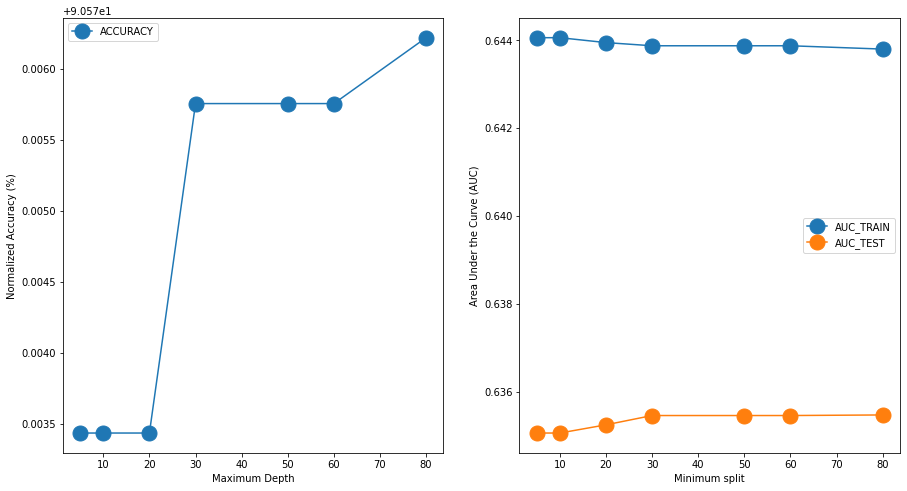

In [97]:
fig_1 = plt.figure(figsize=(15,8))

fig_1_a = plt.subplot(121)
ax1 = performance_df.plot(x = 'min_split', y = 'ACCURACY', ax = fig_1_a, style = 'o-', markersize =15)
ax1.set_ylabel("Normalized Accuracy (%)")
ax1.set_xlabel("Maximum Depth")

fig_1_b = plt.subplot(122)
ax2 = performance_df.plot(x = 'min_split', y = 'AUC_TRAIN', ax = fig_1_b, style = 'o-', markersize =15)
ax2 = performance_df.plot(x = 'min_split', y = 'AUC_TEST', ax = fig_1_b, style = 'o-', markersize =15)
ax2.set_xlabel("Minimum split")
ax2.set_ylabel("Area Under the Curve (AUC)")
# ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

Here, I decided to set min_split = 5, since AUC, accuracy and F1 value does not change much regarding min_split.

### 1.2.5. Plot coefficient values or feature importance.

In [98]:
estimator = DecisionTreeClassifier(criterion = 'gini',random_state=1147, max_depth = 5,min_samples_split=5)
model_dt  = estimator.fit(X_train_monthly, y_train_monthly)

In [99]:
# Calculate feature importances
importances = model_dt.feature_importances_
importances

array([0.03446127, 0.        , 0.00406807, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.01182647, 0.        ,
       0.        , 0.        , 0.01301226, 0.        , 0.        ,
       0.01361508, 0.        , 0.        , 0.0369517 , 0.        ,
       0.        , 0.00367094, 0.64642586, 0.08229821, 0.14586566,
       0.        , 0.00780447, 0.        ])

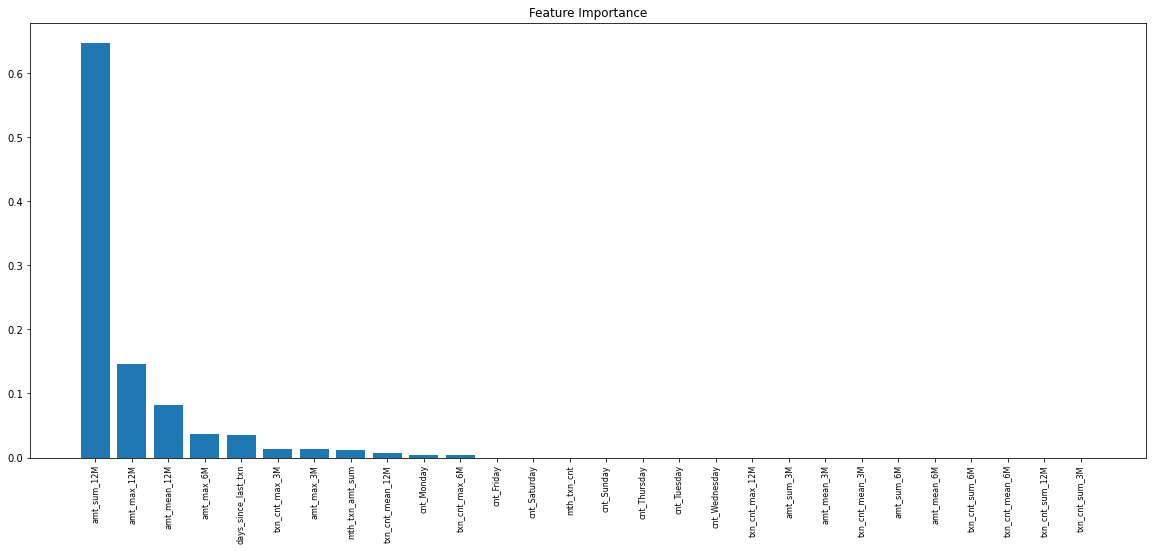

In [100]:
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X_monthly.columns[i] for i in indices]

# Create plot
plt.figure(figsize=(20, 8))
# Create plot title
plt.title("Feature Importance")
# Add bars
plt.bar(range(X_monthly.shape[1]), importances[indices])
# Add feature names as x-axis labels
plt.xticks(range(X_monthly.shape[1]), names, rotation=90,size=8)
# Show plot
plt.show()


Here we can see that very few features has significant effect on decision tree performance.

### 1.2.6. Plot probability distribution for test set.

In [101]:
y_test_proba = model_dt.predict_proba(X_test_monthly)

In [102]:
# How many different probabilities of defaulting are there and how many clients in each?
unique_elements, counts_elements = np.unique(y_test_proba[:,1], return_counts=True)
print("Frequency of unique values of the said array:")
print(unique_elements)
print(counts_elements)

Frequency of unique values of the said array:
[0.         0.01270802 0.02896725 0.03300825 0.03656417 0.05405405
 0.05634573 0.0704388  0.07089258 0.0798274  0.09234788 0.09366869
 0.09669983 0.10736111 0.12106703 0.12276215 0.12699845 0.15584178
 0.16901408 0.20470383 0.375      0.5        0.51724138 0.73333333
 1.        ]
[  231  6728  1713  2726 32648   178  3806 26272 10136  1892 26240  2324
 16182 14473  3006   838 30953 32520   247  2449    44     6    55    20
    12]


Text(0, 0.5, 'Counts of clients')

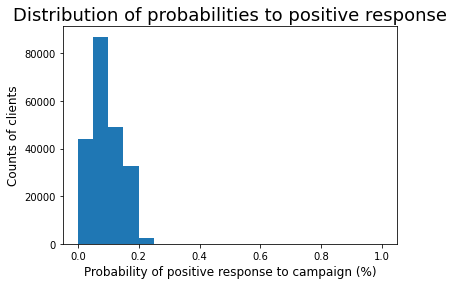

In [103]:
plt.hist(y_test_proba[:,1],bins=20)
plt.title('Distribution of probabilities to positive response',size=18)
plt.xlabel('Probability of positive response to campaign (%)',size=12)
plt.ylabel('Counts of clients',size=12)

Here, almost all of the clients have low probability to positive response.

### 7. Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall.

In [104]:
y_test_predicted = model_dt.predict(X_test_monthly)
cmt = confusion_matrix(y_test_monthly, y_test_predicted)
print(cmt)

[[195338     59]
 [ 20274     28]]


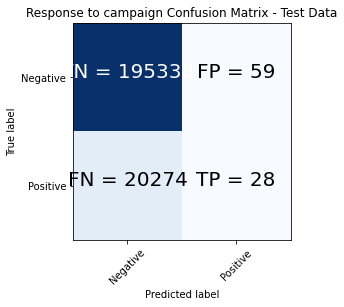

In [105]:
plt.clf()
plt.imshow(cmt, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
plt.title('Response to campaign Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
thresh = cmt.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cmt[i][j]), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cmt[i, j] > thresh else "black")
plt.show()

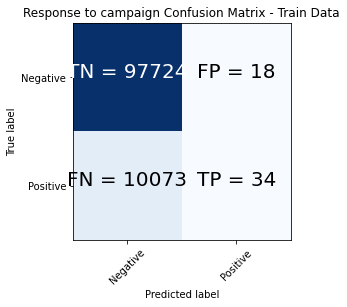

In [106]:
y_train_predicted = model_dt.predict(X_train_monthly)
cmtr = confusion_matrix(y_train_monthly, y_train_predicted)

plt.clf()
plt.imshow(cmtr, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
plt.title('Response to campaign Confusion Matrix - Train Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
thresh = cmtr.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cmtr[i][j]), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cmtr[i, j] > thresh else "black")
plt.show()

ROC curve

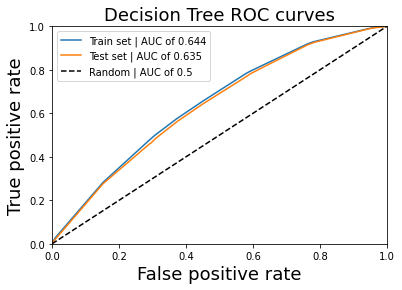

In [107]:
# Scores for train set
scores_train = model_dt.predict_proba(X_train_monthly)[:, 1]
# Scores for test set
scores_test = model_dt.predict_proba(X_test_monthly)[:, 1]

# ROC Calc Train set
fpr_train, tpr_train, _ = roc_curve(y_train_monthly, scores_train)
# ROC Calc Test set
fpr_test, tpr_test, _ = roc_curve(y_test_monthly, scores_test)
# AUC Calc
auc_train = auc(fpr_train, tpr_train)
# AUC Calc
auc_test  = auc(fpr_test, tpr_test)

# Plotting
plt.plot(fpr_train, tpr_train, label='Train set | AUC of {:4.3f}'.format(auc_train));
plt.plot(fpr_test, tpr_test, label='Test set | AUC of {:4.3f}'.format(auc_test));
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5');
plt.ylim([0,1.0])
plt.xlim([0,1.0])
plt.title('Decision Tree ROC curves', fontsize = 18)
plt.ylabel('True positive rate', fontsize = 18)
plt.xlabel('False positive rate', fontsize = 18)
plt.legend()
plt.show()

Calculate precision/recall

In [108]:
print(classification_report(y_test_monthly, y_test_predicted, target_names = ['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.91      1.00      0.95    195397
    Positive       0.32      0.00      0.00     20302

    accuracy                           0.91    215699
   macro avg       0.61      0.50      0.48    215699
weighted avg       0.85      0.91      0.86    215699



### 1.2.8. Plot decision boundary for top 2 features.

From the feature importance plot, we can observe that the top 2 features are amt_sum_12M & amt_max_12M.

Then we confirm that amt_sum_12M, index=22, has min=0, max=1217

amt_max_12M, index=24, has min=0, max=460

In [109]:
print(X_train_monthly.columns[22])
print(X_train_monthly.columns[24])
print(X_train_monthly.min(axis=0).values[22])
print(X_train_monthly.max(axis=0).values[22])
print(X_train_monthly.min(axis=0).values[24])
print(X_train_monthly.max(axis=0).values[24])

amt_sum_12M
amt_max_12M
0.0
1217.0
0.0
460.0


In [110]:
xx, yy = np.mgrid[0:1217:135, 0:460:51] 
grid = np.c_[xx.ravel(), yy.ravel()]
print(grid.shape) # Confirm that grid shape is 10x10

# np.ones is a table full of ones with 100x75 dimension
# np.median calculates the median of every column in the X_train along axis=0 (i.e. column)
median_inputs = np.ones((100, 28)) * np.median(X_train_monthly, axis=0) 
pd.DataFrame(median_inputs) # Convert to pandas is not necessary. Just doing it here to have a nice view of the table

# Then, we replace the 5th and 11th column with the values of the grid
median_inputs[:,22] = grid[:,0]
median_inputs[:,24] = grid[:,1]
df = pd.DataFrame(median_inputs).iloc[:13,20:30] # Convert to pandas is not necessary. Just doing it here to have a nice view of the table
df.style.apply(lambda x: ['background: grey' if (x.name == 22)|(x.name == 24)  else '' for i in x])

(100, 2)


,20,21,22,23,24,25,26,27
0,0.333333,1.000000,0.000000,17.916667,0.000000,4.000000,0.333333,1.000000
1,0.333333,1.000000,0.000000,17.916667,51.000000,4.000000,0.333333,1.000000
2,0.333333,1.000000,0.000000,17.916667,102.000000,4.000000,0.333333,1.000000
3,0.333333,1.000000,0.000000,17.916667,153.000000,4.000000,0.333333,1.000000
4,0.333333,1.000000,0.000000,17.916667,204.000000,4.000000,0.333333,1.000000
5,0.333333,1.000000,0.000000,17.916667,255.000000,4.000000,0.333333,1.000000
6,0.333333,1.000000,0.000000,17.916667,306.000000,4.000000,0.333333,1.000000
7,0.333333,1.000000,0.000000,17.916667,357.000000,4.000000,0.333333,1.000000
8,0.333333,1.000000,0.000000,17.916667,408.000000,4.000000,0.333333,1.000000
9,0.333333,1.000000,0.000000,17.916667,459.000000,4.000000,0.333333,1.000000


/Users/tongfeili/Library/Python/3.7/lib/python/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"


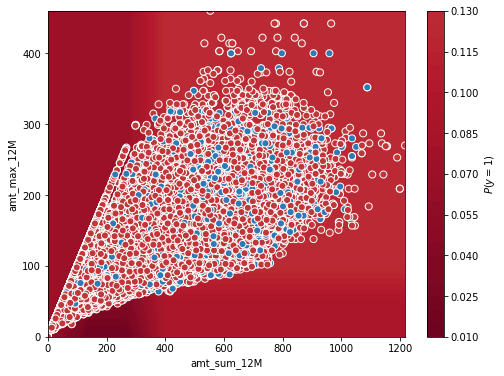

In [111]:
probs = model_dt.predict_proba(median_inputs)[:, 1].reshape(xx.shape)

f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
# ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X_train_monthly['amt_sum_12M'][1000:], X_train_monthly['amt_max_12M'][1000:], c=y_train_monthly[1000:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)
# plt.annotate('Node #6 \n P(default) = 69.9%', xy=(5,1), xycoords='data',horizontalalignment= 'center', fontsize = 14)
# plt.annotate('Node #2 \n P = 15.0%', xy=(-0.5,0.5), xycoords='data',horizontalalignment= 'center', fontsize = 14)
# plt.annotate('Node #5 \n P = 43.1%', xy=(-0.5,6.0), xycoords='data',horizontalalignment= 'center', fontsize = 14)

ax.set(aspect="auto",
       xlim=(0, 1217), ylim=(0, 460),
       xlabel="amt_sum_12M", ylabel="amt_max_12M")
plt.show()

## Monthly Features -- Random Forest

### 1.2.4. Fit the training dataset and optimize the hyperparameters of the method.

In [112]:
# Initiate some parameters that I want to track in the iteration below
max_depth_range = range(2, 12)
estimator_max_depth = []
accuracy_normalized = []
auc_train           = []
auc_test            = []
f1_test             = []
f1_train            = []

for i in max_depth_range:
    # Define and fit
    estimator_max_depth.append(RandomForestClassifier(n_estimators = 200, max_depth = i, random_state=1147))
    estimator_max_depth[i-2].fit(X_train_monthly, y_train_monthly)
    # Score train and test set ############### we don't need to store this in every iteration so we can overwrite it ###############
    scores_train = estimator_max_depth[i-2].predict_proba(X_train_monthly)[:,1] 
    scores_test  = estimator_max_depth[i-2].predict_proba(X_test_monthly)[:,1]  
    # Predict the class of test & train set
    y_test_predicted = estimator_max_depth[i-2].predict(X_test_monthly)
    y_train_predicted = estimator_max_depth[i-2].predict(X_train_monthly)
    # Calculate accuracy at every iteration and append
    accuracy_normalized.append(100*accuracy_score(y_test_monthly, y_test_predicted, normalize = True))
    # ROC Calc Train set ############### we don't need to store this in every iteration so we can overwrite it ###############
    fpr_train, tpr_train, _ = roc_curve(y_train_monthly, scores_train)
    # ROC Calc Test set ############### we don't need to store this in every iteration so we can overwrite it ###############
    fpr_test, tpr_test, _ = roc_curve(y_test_monthly, scores_test)
    # Calculate the AUCs
    auc_train.append(auc(fpr_train, tpr_train))
    auc_test.append(auc(fpr_test, tpr_test))
    # Calculate F1
    f1_test.append(100*f1_score(y_test_monthly, y_test_predicted))
    f1_train.append(100*f1_score(y_train_monthly, y_train_predicted))

In [113]:
performance_dictionary = {'ACCURACY': accuracy_normalized, 
                          'AUC_TRAIN': auc_train,
                          'AUC_TEST': auc_test,
                          'F1_TEST': f1_test,
                          'F1_TRAIN': f1_train}
performance_df = pd.DataFrame(performance_dictionary)
performance_df['MAX_DEPTH'] = performance_df.index + 2
performance_df

,ACCURACY,AUC_TRAIN,AUC_TEST,F1_TEST,F1_TRAIN,MAX_DEPTH
0,90.58781,0.635887,0.631354,0.0,0.000000,2
1,90.58781,0.641597,0.636155,0.0,0.000000,3
2,90.58781,0.645901,0.638766,0.0,0.000000,4
3,90.58781,0.652696,0.641389,0.0,0.000000,5
4,90.58781,0.661786,0.643234,0.0,0.019786,6
5,90.58781,0.676056,0.645897,0.0,0.019786,7
6,90.58781,0.695925,0.647983,0.0,0.039569,8
7,90.58781,0.721633,0.650596,0.0,0.158181,9
8,90.58781,0.754258,0.653842,0.0,0.296384,10
9,90.58781,0.793188,0.656020,0.0,0.670545,11


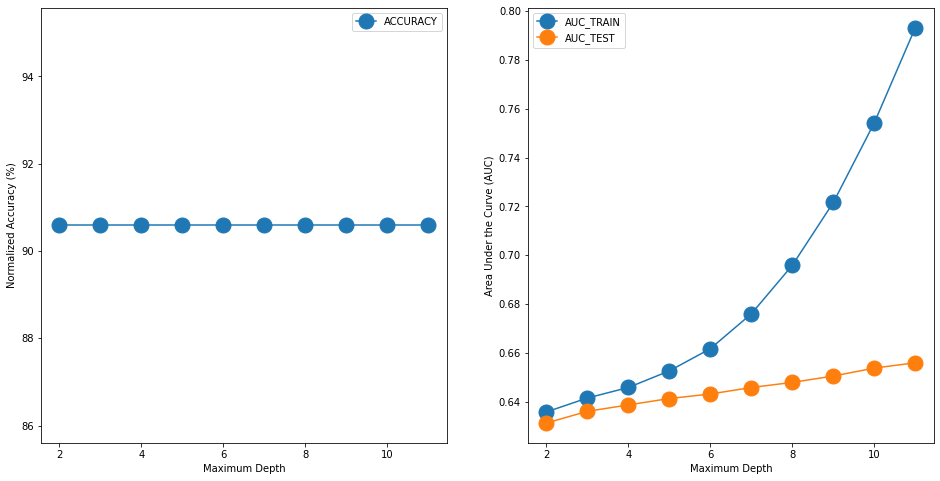

In [114]:
fig_1 = plt.figure(figsize=(16,8))

fig_1_a = plt.subplot(121)
ax1 = performance_df.plot(x = 'MAX_DEPTH', y = 'ACCURACY', ax = fig_1_a, style = 'o-', markersize =15)
ax1.set_ylabel("Normalized Accuracy (%)")
ax1.set_xlabel("Maximum Depth")

fig_1_b = plt.subplot(122)
ax2 = performance_df.plot(x = 'MAX_DEPTH', y = 'AUC_TRAIN', ax = fig_1_b, style = 'o-', markersize =15)
ax2 = performance_df.plot(x = 'MAX_DEPTH', y = 'AUC_TEST', ax = fig_1_b, style = 'o-', markersize =15)
ax2.set_xlabel("Maximum Depth")
ax2.set_ylabel("Area Under the Curve (AUC)")
# ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

Here I choose max_depth = 11, since it maximize F1_train, while we have 90+ accuracy and relatively high AUC_Test & AUC_Train.

In [115]:
# Define and fit
estimator = RandomForestClassifier(random_state=1147, max_depth = 11)
rf_best_model = estimator.fit(X_train_monthly, y_train_monthly)
# Score train and test set ############### we don't need to store this in every iteration so we can overwrite it ###############
scores_train = rf_best_model.predict_proba(X_train_monthly)[:,1] 
scores_test  = rf_best_model.predict_proba(X_test_monthly)[:,1]  
# Predict the class of test set
y_test_predicted = rf_best_model.predict(X_test_monthly)
# Calculate accuracy at every iteration and append
accuracy = 100*accuracy_score(y_test_monthly, y_test_predicted, normalize = True)
# ROC Calc Train set 
fpr_train, tpr_train, _ = roc_curve(y_train_monthly, scores_train)
# ROC Calc Test set
fpr_test, tpr_test, _ = roc_curve(y_test_monthly, scores_test)
# Calculate the AUCs
auc_train = auc(fpr_train, tpr_train)
auc_test  = auc(fpr_test, tpr_test)

### 1.2.5. Plot coefficient values or feature importance.

In [116]:
# Calculate feature importances
importances = rf_best_model.feature_importances_
print(importances)
print(importances.shape)

[0.07810978 0.00608367 0.00630094 0.00678628 0.00706469 0.00532821
 0.00478799 0.0071806  0.03377822 0.00682519 0.04924147 0.050188
 0.05142294 0.00950652 0.00999551 0.00681015 0.0679578  0.07630699
 0.07328762 0.01587484 0.01499329 0.00920103 0.11254279 0.11636679
 0.08571898 0.03335444 0.0370586  0.01792667]
(28,)


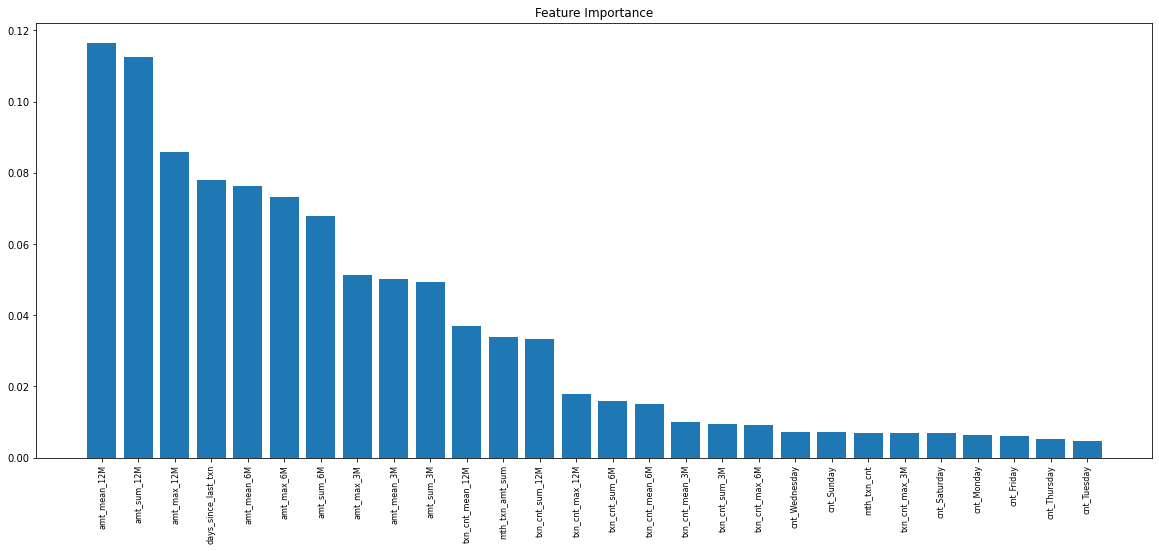

In [117]:
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X_monthly.columns[i] for i in indices]

# Create plot
plt.figure(figsize=(20,8))
# Create plot title
plt.title("Feature Importance")
# Add bars
plt.bar(range(X_monthly.shape[1]), importances[indices])
# Add feature names as x-axis labels
plt.xticks(range(X_monthly.shape[1]), names, rotation=90,size=8)
# Show plot
plt.show()

Here, we can see that the two most important feature is amt_mean_12M & amt_sum_12M.

### 1.2.6. Plot probability distribution for test set.

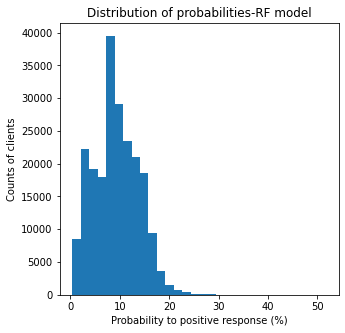

In [118]:
plt.figure(figsize=(5,5))
# sns.displot(data = scores_test, x = 100*scores_test)
plt.hist(100*scores_test,bins=30)
plt.title('Distribution of probabilities-RF model')
plt.xlabel('Probability to positive response (%)')
plt.ylabel('Counts of clients')
plt.show()

### 1.2.7. Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall.

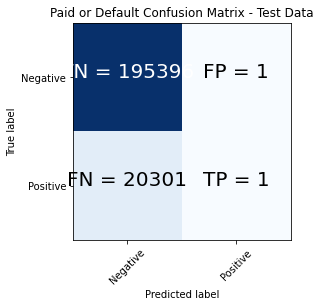

In [119]:
cm = confusion_matrix(y_test_monthly, y_test_predicted)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
plt.title('Paid or Default Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.show()

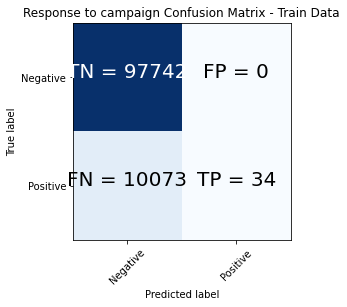

In [120]:
cm = confusion_matrix(y_train_monthly, y_train_predicted)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
plt.title('Response to campaign Confusion Matrix - Train Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.show()

ROC curve

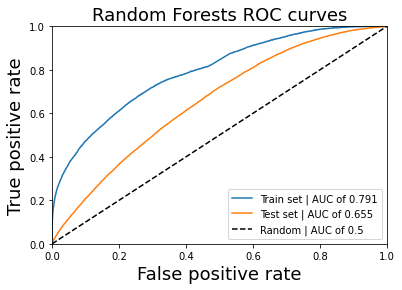

In [121]:
plt.plot(fpr_train, tpr_train, label='Train set | AUC of {:4.3f}'.format(auc_train));
plt.plot(fpr_test, tpr_test, label='Test set | AUC of {:4.3f}'.format(auc_test));
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5');
plt.ylim([0,1.0])
plt.xlim([0,1.0])
plt.title('Random Forests ROC curves', fontsize = 18)
plt.ylabel('True positive rate', fontsize = 18)
plt.xlabel('False positive rate', fontsize = 18)
plt.legend()
plt.show()

Calculate precision/recall

In [122]:
print(classification_report(y_test_monthly, y_test_predicted, target_names = ['Negetive', 'Positive']))

              precision    recall  f1-score   support

    Negetive       0.91      1.00      0.95    195397
    Positive       0.50      0.00      0.00     20302

    accuracy                           0.91    215699
   macro avg       0.70      0.50      0.48    215699
weighted avg       0.87      0.91      0.86    215699



### 1.2.8. Plot decision boundary for top 2 features.

In [123]:
# confirm amt_mean_12M has index 23, min=0, max=101.4
# confirm amt_sum_12M has index 22, min=0, max=1217
print(X_train_monthly.columns[23])
print(X_train_monthly.columns[22])

print(X_train_monthly.min(axis=0).values[23])
print(X_train_monthly.max(axis=0).values[23])
print(X_train_monthly.min(axis=0).values[22])
print(X_train_monthly.max(axis=0).values[22])

amt_mean_12M
amt_sum_12M
0.0
101.4166666666667
0.0
1217.0


In [124]:
xx, yy = np.mgrid[0:101.5:11.27, 0:1217:135.2] 
grid = np.c_[xx.ravel(), yy.ravel()]
print(grid.shape) # Confirm that grid shape is 10x10

# np.ones is a table full of ones with 100x23 dimension
# np.median calculates the median of every column in the X_train along axis=0 (i.e. column)
median_inputs = np.ones((100, 28)) * np.median(X_train_monthly, axis=0) 
pd.DataFrame(median_inputs) # Convert to pandas is not necessary. Just doing it here to have a nice view of the table

# Then, we replace the 5th and 11th column with the values of the grid
median_inputs[:,23] = grid[:,0]
median_inputs[:,22] = grid[:,1]
df = pd.DataFrame(median_inputs).iloc[:13,20:30] # Convert to pandas is not necessary. Just doing it here to have a nice view of the table
df.style.apply(lambda x: ['background: grey' if (x.name == 23)|(x.name == 22)  else '' for i in x])

(100, 2)


,20,21,22,23,24,25,26,27
0,0.333333,1.000000,0.000000,0.000000,88.000000,4.000000,0.333333,1.000000
1,0.333333,1.000000,135.200000,0.000000,88.000000,4.000000,0.333333,1.000000
2,0.333333,1.000000,270.400000,0.000000,88.000000,4.000000,0.333333,1.000000
3,0.333333,1.000000,405.600000,0.000000,88.000000,4.000000,0.333333,1.000000
4,0.333333,1.000000,540.800000,0.000000,88.000000,4.000000,0.333333,1.000000
5,0.333333,1.000000,676.000000,0.000000,88.000000,4.000000,0.333333,1.000000
6,0.333333,1.000000,811.200000,0.000000,88.000000,4.000000,0.333333,1.000000
7,0.333333,1.000000,946.400000,0.000000,88.000000,4.000000,0.333333,1.000000
8,0.333333,1.000000,1081.600000,0.000000,88.000000,4.000000,0.333333,1.000000
9,0.333333,1.000000,1216.800000,0.000000,88.000000,4.000000,0.333333,1.000000


/Users/tongfeili/Library/Python/3.7/lib/python/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


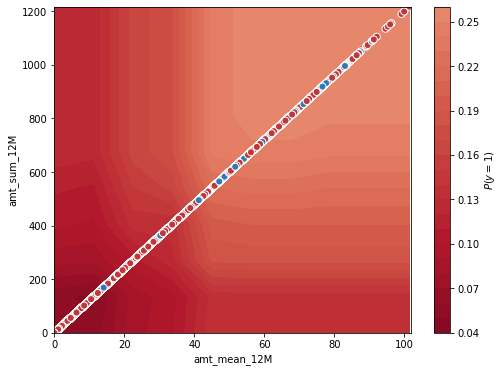

In [125]:
probs = rf_best_model.predict_proba(median_inputs)[:, 1].reshape(xx.shape)
f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
# ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X_train_monthly['amt_mean_12M'][50:], X_train_monthly['amt_sum_12M'][50:], c=y_train_monthly[50:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)
# plt.annotate('P = 45.0%', xy=(5,0), xycoords='data',horizontalalignment= 'center', verticalalignment= 'center', fontsize = 14)
# plt.annotate('P = 12.8%', xy=(-0.8,0.35), xycoords='data', horizontalalignment= 'center', fontsize = 14)
# plt.annotate('P = 27.2%', xy=(-0.8,6.0), xycoords='data', horizontalalignment= 'center', verticalalignment= 'center', fontsize = 14)
# plt.annotate('P = 55.1%', xy=(6.0,3.0), xycoords='data', horizontalalignment= 'center', verticalalignment= 'center', fontsize = 14)
# plt.annotate('P = 27.2%', xy=(7.0,4.5), xycoords='data', horizontalalignment= 'center', verticalalignment= 'center', fontsize = 14)

ax.set(aspect="auto",
       xlim=(0, 102), ylim=(0, 1217),
       xlabel="amt_mean_12M", ylabel="amt_sum_12M")
plt.show()

# 1.3 Comparison of methods (10 points)


In [126]:
print(sum(Retail_Data_Response.response.values)/len(Retail_Data_Response.response.values)*100,'% of clients response positively to promotional campaign.')

9.39860546194073 % of clients response positively to promotional campaign.


## Compare the two feature engineering (annual and monthly) and the three modeling approaches (L1 log-reg, tree, forests) in terms of the outcomes of steps 5-8. 


### Compare the two feature engineering (annual and monthly)

For **complexity/computation efficiancy**, annual data has a much lower running time when I run it, because monthly data has much more rows than annual data.

For **Presition/Recall**, all monthly models has 0 recall value, all clients that should have positive response are predicted as negative. Anuual models also have low recall value of less than 15%. 

For **AUC**, Annual models has higher AUC value than monthly models, both on training and testing dataset, so annual models explains more variation of the data than monthly models.

For **probability distribution**, All density of distribution located at low outcome(less than 50%). Random Forest of annual models predicts all negative outcomes, Log-reg and Random Forest of monthly models predicts all negative outcomes, if we want anomaly detection of class 1, we must not choose them. probability distribution of annual samples are right-skewed, while distribution of monthly samples are more closed to normal distribution.

Comparing **Important Features**, we can observe that all 6 models chooses transacton amount sum as one of their top 2 features, which means that sum of transaction amount has strong relationship with promotional campaign result. Annual models all chooses transacton amount sum at years of 2013 & 2014, so we can guess that clients behaviour in these two years matters most to promotional campaign result. Monthly models all chooses 12 month rolling features, so we can guess that customers behaviours in range of 12 month are more likely to explain their choice in promotional campaign.

### Compare three modeling approaches (L1 log-reg, tree, forests)


For **Presition/Recall**, Random Forest seems to have higher precision value than other two appraches in both annual and monthly models. All three approaches has low Recall value.

For **AUC**, Random Forest seems to have higher AUC_train than Decision Tree, than L1 Logistic regression, but AUC_test does not varies much among these three approaches.

For **probability distribution**, Random Forest approaches has all probability lesss than 50%, it does not predict positive outcome. Decision Tress of both annual and monthly models can predict positive outcome. Logistic Regression model predicts few >50% probabilities on annual feature engineering, but for monthly one, it still predicts all negative response.

**Important Features**, All approaches from annual models chooses ann_txn_amt_sum_2013 & 2014 as top 2 important features, all approaches from monthly chooses amt_sum_12M as one of their important features.

### General Comparison of 6 models

Of all the 6 models, we can see that they all have low Precision values (less than 50%), and extremly low Recall (less than 20%). Which means the models have very bad behaviour at predicting outcome 1 (positive response to promotional campaign). My conjecture to the cause of this phenomenon is highly imbalanced data. We can see that only 9.4% of clients response positively to promotional campaign, so more than 90% of our dataset leads to a response value 0.

For logistic Regression models, it tends to minimize MSE, or sum of square distances between predicted and actual value, with a highly imbalanced data that most of the observations are 0, the model would predict much more 0s to minimize its error. For Decision Tree models, it tries to select the majority class as its prediction value within a defined range, therefore it is more likely to give a negative prediction, since the points with value 0 has much higher density than points with value 1. For Random Forest, it is similar to Decision Tree since it is a optimization approach of trees.

Therefore, I would say that the highly imbalanced data can be a major reason for low Recall and Precision.

## Which combination of feature engineering and modeling approach do you select as the best to deploy in a production environment and why? 

I would choose L1 logistic regression with annual data. It has relatively highest AUC_Test value (0.76) compared to the other 5 models, while AUC_Train (0.8) is closed to AUC_Test, which means there's no concerns of overfitting or underfitting, and our L1 log-reg model explains 80% of variantion train dataset and 76% of variation of test dataset.

### Suggestions for future improvements

Annual Models: I would test correlation between features, and remove features with high correlaton. Since I believe that some of the features have high correlation or perfect linear/quadratic relationship, like txn_amt_ave & txn_amt_sum, and ann_txn_amt_std & ann_txn_amt_var, such featues with high covariance would cause multicollinearity, which can affect the acccuracy and interepretation of our models.

Monthly Models: I would like to add 18 Month and 24 Month rolling features for Monthly models, since right now all the approaches tends to choose 12M as important feature, so I would say that a longer-term transaction behaviour of clients tends to have larger relationship to promotional campaign result.

From ****General Comparison of 6 models****, we discussed that the data is highly imbalanced, which leads to low Precision and Recall, if we want to improve this performance, we may need to use a different model that performs better on imbalanced data, or try to select a balanced dataset with closed number of each response classes.


| Feature | modeling approach |     Important Features      |  AUC_Train |  AUC_Test  | Precision | Recall |
| ------- | ----------------- | --------------------------- | ---------- | ---------- | --------- | ------ |
| Annual  |    L1 log-reg     | ann_txn_amt_sum_2013 & 2014 |    0.80    |    0.76    |    0.21   |  0.01  |
| Annual  |   Decision Tree   | ann_txn_amt_sum_2013 & 2014 |    0.95    |    0.67    |    0.23   |  0.15  |
| Annual  |   Random Forest   | ann_txn_amt_sum_2013 & 2014 |    1.00    |    0.73    |    0.75   |  0.01  |
| Monthly |    L1 log-reg     | amt_mean_12M & amt_sum_12M  |    0.63    |    0.63    |    0.00   |  0.00  |
| Monthly |   Decision Tree   | amt_max_12M & amt_sum_12M   |    0.65    |    0.64    |    0.32   |  0.00  |
| Monthly |   Random Forest   | amt_mean_12M & amt_sum_12M  |    0.79    |    0.66    |    0.50   |  0.00  |

| Feature | modeling approach |     Probability  Distribution      |
| ------- | ----------------- | ---------------------------------- |
| Annual  |    L1 log-reg     | Right skewed, most of the clients have low probability(< 30%) of positive resonse, very few people have (> 50%) possibility of positive response. | 
| Annual  |   Decision Tree   | Most samples in test dataset has low probability (less than 0.2) to respond positively to the promotional campaign, while very few of them has >50% probability, the distribution of probability of clients is right skewed. |
| Annual  |   Random Forest   | Distribution on Test data is right skewed and all prediction is less than 50% (all negative prediction) |
| Monthly |    L1 log-reg     | Right skewed, most of the clients have low probability(around 10%) of positive resonse, very few people have more than 20% possibility of positive response. All prediction is less than 50%  |
| Monthly |   Decision Tree   | Almost all of the clients have low probability to positive response (0-30%), very few of them has high probability.   |
| Monthly |   Random Forest   | Almost all of the clients have low probability to positive response (0-30%), all prediction is less than 50%  |